In [ ]:
pip install pandas
pip install torch
pip install numpy
pip install scikit-learn
pip install matplotlib

SyntaxError: invalid syntax (ipython-input-4199779277.py, line 1)

In [ ]:
pip install matplotlib

In [ ]:
pip install torch

## 테스트 코드

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# --- 1. 설정 (Configuration) ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-27",
    "test_start_date": "2025-11-24", # 이 시점부터 테스트 데이터

    "seq_length": 5,          # 시퀀스 길이
    "predict_horizon": 5,     # 며칠 뒤를 예측할 것인가

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,         # 출력 차원 (Close Price)

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 100,
    "learning_rate": 0.001,   # [수정] 학습률을 조금 낮춰 안정화 (0.005 -> 0.001)
    "patience": 10,           # Early Stopping

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. 데이터 전처리 ---
def load_and_process_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"파일을 찾을 수 없습니다: {config['data_file']}")

    # 인코딩 자동 감지 로직
    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'euc-kr', 'latin1']
    df = None

    for enc in encodings_to_try:
        try:
            # 탭(\t)으로 분리 시도
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1:
                df = temp_df
                print(f"-> 성공: 인코딩 '{enc}', 구분자 '탭(\\t)'")
                break

            # 쉼표(,)로 분리 재시도
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1:
                df = temp_df
                print(f"-> 성공: 인코딩 '{enc}', 구분자 '쉼표(,)'")
                break
        except Exception:
            continue

    if df is None:
        raise ValueError("파일을 읽을 수 없습니다.")

    print(f"로드된 데이터 크기: {df.shape}")
    print(f"컬럼 목록: {df.columns.tolist()}")

    # [수정] 데이터 타입 강제 변환 및 결측치 처리 강화
    # 1. 모든 컬럼을 숫자형(float)으로 변환 (오류 발생 시 NaN으로 처리)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 2. 날짜 필터링
    df = df.loc[config["data_start"]:config["data_end"]]

    # 3. 결측치(NaN) 처리 - 경고 해결을 위해 ffill(), bfill() 사용
    df = df.ffill()
    df = df.bfill()
    df.dropna(inplace=True)

    if df.empty:
        raise ValueError(f"유효한 데이터가 없습니다. 날짜 범위나 데이터 내용을 확인해주세요.")

    # 4. 무한대 값(inf) 처리
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    print(f"전처리 후 데이터 크기: {df.shape}")

    # Feature와 Target 분리
    df.columns = [c.strip() for c in df.columns]
    target_col = "KOSPI_Close"

    if target_col not in df.columns:
         possible_cols = [c for c in df.columns if "Close" in c and "KOSPI" in c]
         if possible_cols:
             target_col = possible_cols[0]
             print(f"주의: '{target_col}'를 Target 컬럼으로 사용합니다.")
         else:
             raise KeyError(f"Target 컬럼 '{target_col}'을 찾을 수 없습니다.")

    feature_cols = df.columns.tolist()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Target 컬럼 인덱스
    target_idx = feature_cols.index(target_col)

    # 시퀀스 데이터 생성
    X, y = [], []
    seq_len = config["seq_length"]

    for i in range(len(scaled_data) - seq_len):
        X.append(scaled_data[i : i + seq_len])
        y.append(scaled_data[i + seq_len, target_idx])

    X = np.array(X)
    y = np.array(y)

    # [추가] 시퀀스 생성 후에도 NaN이 있는지 최종 확인
    if np.isnan(X).any() or np.isnan(y).any():
        print("경고: 전처리 후 데이터에 NaN이 발견되었습니다. 제거합니다.")
        valid_idx = ~np.isnan(X).any(axis=(1, 2)) & ~np.isnan(y)
        X = X[valid_idx]
        y = y[valid_idx]

    # 학습/테스트 분리
    dates = df.index[seq_len:]
    # 데이터 포인트 제거로 인해 dates 길이도 맞춰줘야 할 수 있음
    if len(dates) != len(X):
        dates = dates[:len(X)]

    test_start = pd.Timestamp(config["test_start_date"])

    train_mask = dates < test_start
    test_mask = dates >= test_start

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    if len(X_train) == 0 or len(X_test) == 0:
        raise ValueError("학습 또는 테스트 데이터가 비어있습니다. 날짜 설정이나 데이터 기간을 확인해주세요.")

    # Tensor 변환
    X_train = torch.FloatTensor(X_train).to(config['device'])
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(config['device'])
    X_test = torch.FloatTensor(X_test).to(config['device'])
    y_test = torch.FloatTensor(y_test).unsqueeze(1).to(config['device'])

    return X_train, y_train, X_test, y_test, scaler, target_idx

# --- 3. 모델 정의 ---

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. 학습 및 평가 함수 ---
def train_model(model, train_loader, config):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    model.train()
    loss_history = []

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # [추가] Loss가 NaN이면 중단
            if torch.isnan(loss):
                print(f"  경고: Epoch {epoch+1}에서 Loss가 NaN입니다. 학습을 중단합니다.")
                return model, loss_history

            loss.backward()

            # [추가] Gradient Clipping (기울기 폭주 방지)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch [{epoch+1}/{config['epochs']}], Loss: {avg_loss:.6f}")

        if config["patience"]:
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config["patience"]:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break

    return model, loss_history

def evaluate_model(model, X_test, y_test, scaler, target_idx, config):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        y_true = y_test.cpu().numpy()

    def inverse_scale(data_1d):
        dummy = np.zeros((len(data_1d), scaler.n_features_in_))
        dummy[:, target_idx] = data_1d.flatten()
        return scaler.inverse_transform(dummy)[:, target_idx]

    pred_inverse = inverse_scale(predictions)
    true_inverse = inverse_scale(y_true)

    rmse = np.sqrt(mean_squared_error(true_inverse, pred_inverse))
    return rmse, true_inverse, pred_inverse

# --- 5. 메인 실행 ---
def main():
    print("1. 데이터 로드 및 전처리...")
    try:
        X_train, y_train, X_test, y_test, scaler, target_idx = load_and_process_data(CONFIG)
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return

    input_size = X_train.shape[2]
    print(f"   Input Features: {input_size}, Train Size: {len(X_train)}, Test Size: {len(X_test)}")

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)

    models = {
        "LSTM": LSTMModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"]),
        "CNN + LSTM": CNNLSTMModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"], CONFIG["num_filters"], CONFIG["kernel_size"]),
        "LSTM (Attention)": LSTMAttentionModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"])
    }

    results = {}

    print("\n2. 모델 학습 시작...")
    for name, model in models.items():
        print(f"\n[{name}] Training...")
        model.to(CONFIG['device'])

        trained_model, _ = train_model(model, train_loader, CONFIG)

        rmse, y_true, y_pred = evaluate_model(trained_model, X_test, y_test, scaler, target_idx, CONFIG)
        results[name] = rmse
        print(f"  >> {name} RMSE: {rmse:.4f}")

    print("\n3. 최종 결과 비교 (RMSE)")
    df_results = pd.DataFrame(list(results.items()), columns=["Model", "RMSE"])
    df_results = df_results.sort_values(by="RMSE")
    print("--------------------------------------------------")
    print(df_results)
    print("--------------------------------------------------")

    df_results.to_csv("model_rmse_comparison.csv", index=False)
    print("결과가 'model_rmse_comparison.csv'로 저장되었습니다.")

if __name__ == "__main__":
    main()

RuntimeError: Only a single TORCH_LIBRARY can be used to register the namespace prims; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /usr/local/lib/python3.12/dist-packages/torch/_prims/__init__.py:37; latest registration was registered at /usr/local/lib/python3.12/dist-packages/torch/_prims/__init__.py:37

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import matplotlib.font_manager as fm

# 한글 폰트 설정 (그래프용)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'
except:
    plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. 설정 (Configuration) ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28", # [수정] 11월 28일까지 확인하기 위해 연장
    "test_start_date": "2025-11-24", # 이 시점부터 테스트 데이터

    # [추가] Feature 선택 (원하는 Feature만 리스트에 남기세요. 비워두거나 None이면 전체 사용)
    "selected_features": [
        'KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume',
        'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown',
        'NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change',
        'USD_KRW', 'EUR_KRW', 'Rate',
        'VKOSPI_Close', 'VKOSPI_Change',
        'Future_Close', 'Future_Change',
        'WTI_Close', 'WTI_Change',
        'Foreign_MarketCap_Ratio', 'Foreign_MarketCap'
    ],
    # "selected_features": None, # 전체 Feature 사용 시 주석 해제

    "seq_length": 5,          # 시퀀스 길이
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 100,
    "learning_rate": 0.001,
    "patience": 10,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. 데이터 전처리 ---
def load_and_process_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"파일을 찾을 수 없습니다: {config['data_file']}")

    # 인코딩 자동 감지 로직
    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'euc-kr', 'latin1']
    df = None

    for enc in encodings_to_try:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1:
                df = temp_df
                print(f"-> 성공: 인코딩 '{enc}', 구분자 '탭(\\t)'")
                break

            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1:
                df = temp_df
                print(f"-> 성공: 인코딩 '{enc}', 구분자 '쉼표(,)'")
                break
        except Exception:
            continue

    if df is None:
        raise ValueError("파일을 읽을 수 없습니다.")

    print(f"로드된 전체 데이터 크기: {df.shape}")

    # 데이터 타입 강제 변환
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 날짜 필터링
    df = df.loc[config["data_start"]:config["data_end"]]

    # 결측치 처리
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    if df.empty:
        raise ValueError(f"유효한 데이터가 없습니다.")

    # 컬럼 공백 제거
    df.columns = [c.strip() for c in df.columns]

    # Target 설정
    target_col = "KOSPI_Close"
    if target_col not in df.columns:
         possible_cols = [c for c in df.columns if "Close" in c and "KOSPI" in c]
         if possible_cols:
             target_col = possible_cols[0]
         else:
             raise KeyError(f"Target 컬럼 '{target_col}'을 찾을 수 없습니다.")

    # [수정] Feature Selection 적용
    if config.get("selected_features"):
        selected = config["selected_features"]
        # Target 컬럼은 반드시 포함되어야 함
        if target_col not in selected:
            selected.append(target_col)

        # 실제 데이터프레임에 존재하는 컬럼만 선택
        available_cols = [c for c in selected if c in df.columns]
        missing_cols = set(selected) - set(available_cols)
        if missing_cols:
            print(f"[경고] 다음 Feature는 데이터에 없어 제외됩니다: {missing_cols}")

        df = df[available_cols]
        print(f"-> Feature 선택 적용 완료: {len(df.columns)}개 사용")
    else:
        print(f"-> 전체 Feature 사용: {len(df.columns)}개")

    feature_cols = df.columns.tolist()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Target 컬럼 인덱스
    target_idx = feature_cols.index(target_col)

    # 시퀀스 데이터 생성
    X, y = [], []
    seq_len = config["seq_length"]

    for i in range(len(scaled_data) - seq_len):
        X.append(scaled_data[i : i + seq_len])
        y.append(scaled_data[i + seq_len, target_idx])

    X = np.array(X)
    y = np.array(y)

    # NaN 확인 및 제거
    if np.isnan(X).any() or np.isnan(y).any():
        valid_idx = ~np.isnan(X).any(axis=(1, 2)) & ~np.isnan(y)
        X = X[valid_idx]
        y = y[valid_idx]

    # 학습/테스트 분리
    dates = df.index[seq_len:]
    if len(dates) != len(X):
        dates = dates[:len(X)]

    test_start = pd.Timestamp(config["test_start_date"])

    train_mask = dates < test_start
    test_mask = dates >= test_start

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    # 테스트 데이터의 날짜 인덱스 저장 (그래프 그리기용)
    test_dates = dates[test_mask]

    if len(X_train) == 0 or len(X_test) == 0:
        raise ValueError("학습 또는 테스트 데이터가 비어있습니다.")

    # Tensor 변환
    X_train = torch.FloatTensor(X_train).to(config['device'])
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(config['device'])
    X_test = torch.FloatTensor(X_test).to(config['device'])
    y_test = torch.FloatTensor(y_test).unsqueeze(1).to(config['device'])

    return X_train, y_train, X_test, y_test, scaler, target_idx, test_dates

# --- 3. 모델 정의 ---

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. 학습 및 평가 함수 ---
def train_model(model, train_loader, config):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    model.train()
    loss_history = []

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            if torch.isnan(loss):
                print(f"  경고: Epoch {epoch+1}에서 Loss가 NaN입니다.")
                return model, loss_history

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch [{epoch+1}/{config['epochs']}], Loss: {avg_loss:.6f}")

        if config["patience"]:
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config["patience"]:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break

    return model, loss_history

def evaluate_model(model, X_test, y_test, scaler, target_idx, config):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        y_true = y_test.cpu().numpy()

    def inverse_scale(data_1d):
        dummy = np.zeros((len(data_1d), scaler.n_features_in_))
        dummy[:, target_idx] = data_1d.flatten()
        return scaler.inverse_transform(dummy)[:, target_idx]

    pred_inverse = inverse_scale(predictions)
    true_inverse = inverse_scale(y_true)

    rmse = np.sqrt(mean_squared_error(true_inverse, pred_inverse))
    return rmse, true_inverse, pred_inverse

# [추가] 그래프 그리기 함수
def plot_results(model_name, dates, y_true, y_pred):
    # 날짜와 예측값을 매핑
    df_plot = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred}, index=dates)

    # 11월 24일 ~ 11월 28일 데이터 필터링
    # 데이터가 해당 기간을 포함하는지 확인 후 슬라이싱
    target_start = "2025-11-24"
    target_end = "2025-11-28"
    mask = (df_plot.index >= target_start) & (df_plot.index <= target_end)
    df_subset = df_plot.loc[mask]

    if df_subset.empty:
        print(f"경고: {target_start} ~ {target_end} 기간의 데이터가 없습니다. 전체 테스트 기간을 출력합니다.")
        df_subset = df_plot.tail(20) # 데이터가 없으면 마지막 20일치 출력

    plt.figure(figsize=(12, 6))

    # 실제값 (파란색 선)
    plt.plot(df_subset.index, df_subset['Actual'], label='Actual (KOSPI)', color='blue', marker='o', linewidth=2)

    # 예측값 (빨간색 선)
    plt.plot(df_subset.index, df_subset['Predicted'], label=f'Predicted ({model_name})', color='red', linestyle='--', marker='x', linewidth=2)

    plt.title(f"{model_name}: KOSPI Closing price prediction  ({target_start} ~ {target_end})", fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (KRW)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # 값 표시
    for i in range(len(df_subset)):
        date = df_subset.index[i]
        act = df_subset['Actual'].iloc[i]
        pred = df_subset['Predicted'].iloc[i]
        # 텍스트가 겹치지 않게 위치 조정
        plt.text(date, act, f"{act:.0f}", ha='center', va='bottom', color='blue', fontsize=9)
        plt.text(date, pred, f"{pred:.0f}", ha='center', va='top', color='red', fontsize=9)

    plt.tight_layout()

    filename = f"prediction_plot_{model_name.replace(' ', '_').replace('+', '')}.png"
    plt.savefig(filename, dpi=300)
    print(f"그래프 저장 완료: {filename}")
    plt.close()

# --- 5. 메인 실행 ---
def main():
    print("1. 데이터 로드 및 전처리...")
    try:
        # [수정] test_dates도 반환받음
        X_train, y_train, X_test, y_test, scaler, target_idx, test_dates = load_and_process_data(CONFIG)
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return

    input_size = X_train.shape[2]
    print(f"   Input Features: {input_size}, Train Size: {len(X_train)}, Test Size: {len(X_test)}")

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)

    models = {
        "LSTM": LSTMModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"]),
        "CNN + LSTM": CNNLSTMModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"], CONFIG["num_filters"], CONFIG["kernel_size"]),
        "LSTM (Attention)": LSTMAttentionModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"])
    }

    results = {}

    print("\n2. 모델 학습 시작...")
    for name, model in models.items():
        print(f"\n[{name}] Training...")
        model.to(CONFIG['device'])

        trained_model, _ = train_model(model, train_loader, CONFIG)

        rmse, y_true, y_pred = evaluate_model(trained_model, X_test, y_test, scaler, target_idx, CONFIG)
        results[name] = rmse
        print(f"  >> {name} RMSE: {rmse:.4f}")

        # [추가] 그래프 그리기 호출
        plot_results(name, test_dates, y_true, y_pred)

    print("\n3. 최종 결과 비교 (RMSE)")
    df_results = pd.DataFrame(list(results.items()), columns=["Model", "RMSE"])
    df_results = df_results.sort_values(by="RMSE")
    print("--------------------------------------------------")
    print(df_results)
    print("--------------------------------------------------")

    df_results.to_csv("model_rmse_comparison.csv", index=False)
    print("결과가 'model_rmse_comparison.csv'로 저장되었습니다.")

if __name__ == "__main__":
    main()

RuntimeError: Only a single TORCH_LIBRARY can be used to register the namespace prims; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /usr/local/lib/python3.12/dist-packages/torch/_prims/__init__.py:37; latest registration was registered at /usr/local/lib/python3.12/dist-packages/torch/_prims/__init__.py:37

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28", # Extended to check until Nov 28
    "test_start_date": "2025-11-24", # Test start date

    # Feature Selection (Leave specific features in the list, or set to None to use all)
    "selected_features": [
        'KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume',
        'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown',
        'NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change',
        'USD_KRW', 'EUR_KRW', 'Rate',
        'VKOSPI_Close', 'VKOSPI_Change',
        'Future_Close', 'Future_Change',
        'WTI_Close', 'WTI_Change',
        'Foreign_MarketCap_Ratio', 'Foreign_MarketCap'
    ],
    # "selected_features": None, # Uncomment to use all features

    "seq_length": 5,          # Sequence length
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 100,
    "learning_rate": 0.001,
    "patience": 10,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing ---
def load_and_process_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    # Automatic encoding detection
    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'euc-kr', 'latin1']
    df = None

    for enc in encodings_to_try:
        try:
            # Try tab separator
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1:
                df = temp_df
                print(f"-> Success: Loaded with encoding '{enc}', separator 'Tab(\\t)'")
                break

            # Try comma separator
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1:
                df = temp_df
                print(f"-> Success: Loaded with encoding '{enc}', separator 'Comma(,)'")
                break
        except Exception:
            continue

    if df is None:
        raise ValueError("Failed to read file. Please check encoding or separator.")

    print(f"Total data shape: {df.shape}")

    # Force numeric conversion
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Date filtering
    df = df.loc[config["data_start"]:config["data_end"]]

    # Missing value handling
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    if df.empty:
        raise ValueError(f"No valid data available.")

    # Strip column whitespace
    df.columns = [c.strip() for c in df.columns]

    # Target setup
    target_col = "KOSPI_Close"
    if target_col not in df.columns:
         possible_cols = [c for c in df.columns if "Close" in c and "KOSPI" in c]
         if possible_cols:
             target_col = possible_cols[0]
         else:
             raise KeyError(f"Target column '{target_col}' not found.")

    # Feature Selection
    if config.get("selected_features"):
        selected = config["selected_features"]
        if target_col not in selected:
            selected.append(target_col)

        available_cols = [c for c in selected if c in df.columns]
        missing_cols = set(selected) - set(available_cols)
        if missing_cols:
            print(f"[Warning] Missing features in data: {missing_cols}")

        df = df[available_cols]
        print(f"-> Feature Selection Applied: {len(df.columns)} features used")
    else:
        print(f"-> Using All Features: {len(df.columns)} features")

    feature_cols = df.columns.tolist()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Target column index
    target_idx = feature_cols.index(target_col)

    # Sequence generation
    X, y = [], []
    seq_len = config["seq_length"]

    for i in range(len(scaled_data) - seq_len):
        X.append(scaled_data[i : i + seq_len])
        y.append(scaled_data[i + seq_len, target_idx])

    X = np.array(X)
    y = np.array(y)

    # NaN check
    if np.isnan(X).any() or np.isnan(y).any():
        valid_idx = ~np.isnan(X).any(axis=(1, 2)) & ~np.isnan(y)
        X = X[valid_idx]
        y = y[valid_idx]

    # Train/Test Split
    dates = df.index[seq_len:]
    if len(dates) != len(X):
        dates = dates[:len(X)]

    test_start = pd.Timestamp(config["test_start_date"])

    train_mask = dates < test_start
    test_mask = dates >= test_start

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    # Save test dates for plotting
    test_dates = dates[test_mask]

    if len(X_train) == 0 or len(X_test) == 0:
        raise ValueError("Train or Test set is empty.")

    # Convert to Tensor
    X_train = torch.FloatTensor(X_train).to(config['device'])
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(config['device'])
    X_test = torch.FloatTensor(X_test).to(config['device'])
    y_test = torch.FloatTensor(y_test).unsqueeze(1).to(config['device'])

    return X_train, y_train, X_test, y_test, scaler, target_idx, test_dates

# --- 3. Model Definitions ---

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        # Conv1d: (Batch, Input_Channels, Seq_Len)
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Calculate size after pooling: floor(seq_len / 2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)

    def forward(self, x):
        # x: (Batch, Seq, Feat) -> (Batch, Feat, Seq) for Conv1d
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.flatten(1) # Flatten for FC
        x = self.fc(x)
        return x

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training & Evaluation ---
def train_model(model, train_loader, config):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    model.train()
    loss_history = []

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            if torch.isnan(loss):
                print(f"  Warning: Loss is NaN at Epoch {epoch+1}.")
                return model, loss_history

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch [{epoch+1}/{config['epochs']}], Loss: {avg_loss:.6f}")

        if config["patience"]:
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config["patience"]:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break

    return model, loss_history

def evaluate_model(model, X_test, y_test, scaler, target_idx, config):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        y_true = y_test.cpu().numpy()

    def inverse_scale(data_1d):
        dummy = np.zeros((len(data_1d), scaler.n_features_in_))
        dummy[:, target_idx] = data_1d.flatten()
        return scaler.inverse_transform(dummy)[:, target_idx]

    pred_inverse = inverse_scale(predictions)
    true_inverse = inverse_scale(y_true)

    rmse = np.sqrt(mean_squared_error(true_inverse, pred_inverse))
    return rmse, true_inverse, pred_inverse

# Plotting Function
def plot_results(model_name, dates, y_true, y_pred):
    df_plot = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred}, index=dates)

    # Target period for visualization
    target_start = "2025-11-24"
    target_end = "2025-11-28"
    mask = (df_plot.index >= target_start) & (df_plot.index <= target_end)
    df_subset = df_plot.loc[mask]

    if df_subset.empty:
        print(f"Warning: No data for {target_start} ~ {target_end}. Showing last 20 days.")
        df_subset = df_plot.tail(20)

    plt.figure(figsize=(12, 6))

    # Actual (Blue)
    plt.plot(df_subset.index, df_subset['Actual'], label='Actual (KOSPI)', color='blue', marker='o', linewidth=2)

    # Predicted (Red)
    plt.plot(df_subset.index, df_subset['Predicted'], label=f'Predicted ({model_name})', color='red', linestyle='--', marker='x', linewidth=2)

    plt.title(f"{model_name}: KOSPI Comparison ({target_start} ~ {target_end})", fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (KRW)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Annotate Values
    for i in range(len(df_subset)):
        date = df_subset.index[i]
        act = df_subset['Actual'].iloc[i]
        pred = df_subset['Predicted'].iloc[i]
        plt.text(date, act, f"{act:.0f}", ha='center', va='bottom', color='blue', fontsize=9)
        plt.text(date, pred, f"{pred:.0f}", ha='center', va='top', color='red', fontsize=9)

    plt.tight_layout()

    filename = f"prediction_plot_{model_name.replace(' ', '_').replace('+', '')}.png"
    plt.savefig(filename, dpi=300)
    print(f"Graph Saved: {filename}")
    plt.close()

# --- 5. Main Execution ---
def main():
    print("1. Loading and Preprocessing Data...")
    try:
        X_train, y_train, X_test, y_test, scaler, target_idx, test_dates = load_and_process_data(CONFIG)
    except Exception as e:
        print(f"Error during data loading: {e}")
        return

    input_size = X_train.shape[2]
    print(f"   Input Features: {input_size}, Train Size: {len(X_train)}, Test Size: {len(X_test)}")

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)

    # Model Dictionary
    models = {
        "CNN": CNNModel(input_size, CONFIG["num_classes"], CONFIG["num_filters"], CONFIG["kernel_size"], CONFIG["seq_length"]),
        "LSTM": LSTMModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"]),
        "CNN + LSTM": CNNLSTMModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"], CONFIG["num_filters"], CONFIG["kernel_size"]),
        "LSTM (Attention)": LSTMAttentionModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"])
    }

    results = {}

    print("\n2. Starting Model Training...")
    for name, model in models.items():
        print(f"\n[{name}] Training...")
        model.to(CONFIG['device'])

        trained_model, _ = train_model(model, train_loader, CONFIG)

        rmse, y_true, y_pred = evaluate_model(trained_model, X_test, y_test, scaler, target_idx, CONFIG)
        results[name] = rmse
        print(f"  >> {name} RMSE: {rmse:.4f}")

        plot_results(name, test_dates, y_true, y_pred)

    print("\n3. Final RMSE Comparison")
    df_results = pd.DataFrame(list(results.items()), columns=["Model", "RMSE"])
    df_results = df_results.sort_values(by="RMSE")
    print("--------------------------------------------------")
    print(df_results)
    print("--------------------------------------------------")

    df_results.to_csv("model_rmse_comparison.csv", index=False)
    print("Results saved to 'model_rmse_comparison.csv'.")

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# [수정] 폰트 설정: 코랩 기본 폰트(DejaVu Sans) 강제 지정하여 에러 방지
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28", # Extended to check until Nov 28
    "test_start_date": "2025-11-24", # Test start date

    # Feature Selection (Leave specific features in the list, or set to None to use all)
    "selected_features": [
        'KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume',
        'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown',
        'NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change',
        'USD_KRW', 'EUR_KRW', 'Rate',
        'VKOSPI_Close', 'VKOSPI_Change',
        'Future_Close', 'Future_Change',
        'WTI_Close', 'WTI_Change',
        'Foreign_MarketCap_Ratio', 'Foreign_MarketCap'
    ],
    # "selected_features": None, # Uncomment to use all features

    "seq_length": 5,          # Sequence length
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 100,
    "learning_rate": 0.001,
    "patience": 10,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing ---
def load_and_process_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    # Automatic encoding detection
    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'euc-kr', 'latin1']
    df = None

    for enc in encodings_to_try:
        try:
            # Try tab separator
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1:
                df = temp_df
                print(f"-> Success: Loaded with encoding '{enc}', separator 'Tab(\\t)'")
                break

            # Try comma separator
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1:
                df = temp_df
                print(f"-> Success: Loaded with encoding '{enc}', separator 'Comma(,)'")
                break
        except Exception:
            continue

    if df is None:
        raise ValueError("Failed to read file. Please check encoding or separator.")

    print(f"Total data shape: {df.shape}")

    # Force numeric conversion
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Date filtering
    df = df.loc[config["data_start"]:config["data_end"]]

    # Missing value handling
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    if df.empty:
        raise ValueError(f"No valid data available.")

    # Strip column whitespace
    df.columns = [c.strip() for c in df.columns]

    # Target setup
    target_col = "KOSPI_Close"
    if target_col not in df.columns:
         possible_cols = [c for c in df.columns if "Close" in c and "KOSPI" in c]
         if possible_cols:
             target_col = possible_cols[0]
         else:
             raise KeyError(f"Target column '{target_col}' not found.")

    # Feature Selection
    if config.get("selected_features"):
        selected = config["selected_features"]
        if target_col not in selected:
            selected.append(target_col)

        available_cols = [c for c in selected if c in df.columns]
        missing_cols = set(selected) - set(available_cols)
        if missing_cols:
            print(f"[Warning] Missing features in data: {missing_cols}")

        df = df[available_cols]
        print(f"-> Feature Selection Applied: {len(df.columns)} features used")
    else:
        print(f"-> Using All Features: {len(df.columns)} features")

    feature_cols = df.columns.tolist()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    # Target column index
    target_idx = feature_cols.index(target_col)

    # Sequence generation
    X, y = [], []
    seq_len = config["seq_length"]

    for i in range(len(scaled_data) - seq_len):
        X.append(scaled_data[i : i + seq_len])
        y.append(scaled_data[i + seq_len, target_idx])

    X = np.array(X)
    y = np.array(y)

    # NaN check
    if np.isnan(X).any() or np.isnan(y).any():
        valid_idx = ~np.isnan(X).any(axis=(1, 2)) & ~np.isnan(y)
        X = X[valid_idx]
        y = y[valid_idx]

    # Train/Test Split
    dates = df.index[seq_len:]
    if len(dates) != len(X):
        dates = dates[:len(X)]

    test_start = pd.Timestamp(config["test_start_date"])

    train_mask = dates < test_start
    test_mask = dates >= test_start

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    # Save test dates for plotting
    test_dates = dates[test_mask]

    if len(X_train) == 0 or len(X_test) == 0:
        raise ValueError("Train or Test set is empty.")

    # Convert to Tensor
    X_train = torch.FloatTensor(X_train).to(config['device'])
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(config['device'])
    X_test = torch.FloatTensor(X_test).to(config['device'])
    y_test = torch.FloatTensor(y_test).unsqueeze(1).to(config['device'])

    return X_train, y_train, X_test, y_test, scaler, target_idx, test_dates

# --- 3. Model Definitions ---

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        # Conv1d: (Batch, Input_Channels, Seq_Len)
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Calculate size after pooling: floor(seq_len / 2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)

    def forward(self, x):
        # x: (Batch, Seq, Feat) -> (Batch, Feat, Seq) for Conv1d
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.flatten(1) # Flatten for FC
        x = self.fc(x)
        return x

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training & Evaluation ---
def train_model(model, train_loader, config):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    model.train()
    loss_history = []

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            if torch.isnan(loss):
                print(f"  Warning: Loss is NaN at Epoch {epoch+1}.")
                return model, loss_history

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch [{epoch+1}/{config['epochs']}], Loss: {avg_loss:.6f}")

        if config["patience"]:
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config["patience"]:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break

    return model, loss_history

def evaluate_model(model, X_test, y_test, scaler, target_idx, config):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
        y_true = y_test.cpu().numpy()

    def inverse_scale(data_1d):
        dummy = np.zeros((len(data_1d), scaler.n_features_in_))
        dummy[:, target_idx] = data_1d.flatten()
        return scaler.inverse_transform(dummy)[:, target_idx]

    pred_inverse = inverse_scale(predictions)
    true_inverse = inverse_scale(y_true)

    rmse = np.sqrt(mean_squared_error(true_inverse, pred_inverse))
    return rmse, true_inverse, pred_inverse

# Plotting Function
def plot_results(model_name, dates, y_true, y_pred):
    df_plot = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred}, index=dates)

    # Target period for visualization
    target_start = "2025-11-24"
    target_end = "2025-11-28"
    mask = (df_plot.index >= target_start) & (df_plot.index <= target_end)
    df_subset = df_plot.loc[mask]

    if df_subset.empty:
        print(f"Warning: No data for {target_start} ~ {target_end}. Showing last 20 days.")
        df_subset = df_plot.tail(20)

    plt.figure(figsize=(12, 6))

    # Actual (Blue)
    plt.plot(df_subset.index, df_subset['Actual'], label='Actual (KOSPI)', color='blue', marker='o', linewidth=2)

    # Predicted (Red)
    plt.plot(df_subset.index, df_subset['Predicted'], label=f'Predicted ({model_name})', color='red', linestyle='--', marker='x', linewidth=2)

    plt.title(f"{model_name}: KOSPI Comparison ({target_start} ~ {target_end})", fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (KRW)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Annotate Values
    for i in range(len(df_subset)):
        date = df_subset.index[i]
        act = df_subset['Actual'].iloc[i]
        pred = df_subset['Predicted'].iloc[i]
        plt.text(date, act, f"{act:.0f}", ha='center', va='bottom', color='blue', fontsize=9)
        plt.text(date, pred, f"{pred:.0f}", ha='center', va='top', color='red', fontsize=9)

    plt.tight_layout()

    filename = f"prediction_plot_{model_name.replace(' ', '_').replace('+', '')}.png"
    plt.savefig(filename, dpi=300)
    print(f"Graph Saved: {filename}")
    plt.close()

# --- 5. Main Execution ---
def main():
    print("1. Loading and Preprocessing Data...")
    try:
        X_train, y_train, X_test, y_test, scaler, target_idx, test_dates = load_and_process_data(CONFIG)
    except Exception as e:
        print(f"Error during data loading: {e}")
        return

    input_size = X_train.shape[2]
    print(f"   Input Features: {input_size}, Train Size: {len(X_train)}, Test Size: {len(X_test)}")

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)

    # Model Dictionary
    models = {
        "CNN": CNNModel(input_size, CONFIG["num_classes"], CONFIG["num_filters"], CONFIG["kernel_size"], CONFIG["seq_length"]),
        "LSTM": LSTMModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"]),
        "CNN + LSTM": CNNLSTMModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"], CONFIG["num_filters"], CONFIG["kernel_size"]),
        "LSTM (Attention)": LSTMAttentionModel(input_size, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"])
    }

    results = {}

    print("\n2. Starting Model Training...")
    for name, model in models.items():
        print(f"\n[{name}] Training...")
        model.to(CONFIG['device'])

        trained_model, _ = train_model(model, train_loader, CONFIG)

        rmse, y_true, y_pred = evaluate_model(trained_model, X_test, y_test, scaler, target_idx, CONFIG)
        results[name] = rmse
        print(f"  >> {name} RMSE: {rmse:.4f}")

        plot_results(name, test_dates, y_true, y_pred)

    print("\n3. Final RMSE Comparison")
    df_results = pd.DataFrame(list(results.items()), columns=["Model", "RMSE"])
    df_results = df_results.sort_values(by="RMSE")
    print("--------------------------------------------------")
    print(df_results)
    print("--------------------------------------------------")

    df_results.to_csv("model_rmse_comparison.csv", index=False)
    print("Results saved to 'model_rmse_comparison.csv'.")

if __name__ == "__main__":
    main()

RuntimeError: Only a single TORCH_LIBRARY can be used to register the namespace prims; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /usr/local/lib/python3.12/dist-packages/torch/_prims/__init__.py:37; latest registration was registered at /usr/local/lib/python3.12/dist-packages/torch/_prims/__init__.py:37

##피처 제거 test

Using Device: cuda
Loading Data...
Data range: 2013-08-06 00:00:00 ~ 2025-11-28 00:00:00

[Start Ablation Study]

>> Experiment: Base (All Features)
   [CNN] RMSE: 62.1052
   [LSTM] RMSE: 47.7212
   [CNN+LSTM] RMSE: 60.5714
   [LSTM(Attn)] RMSE: 59.7727

>> Experiment: Remove KOSPI
   [CNN] RMSE: 71.8171
   [LSTM] RMSE: 63.4383
   [CNN+LSTM] RMSE: 38.4365
   [LSTM(Attn)] RMSE: 79.5687

>> Experiment: Remove NASDAQ
   [CNN] RMSE: 64.7363
   [LSTM] RMSE: 47.9368
   [CNN+LSTM] RMSE: 50.9935
   [LSTM(Attn)] RMSE: 64.5198

>> Experiment: Remove VKOSPI
   [CNN] RMSE: 67.3551
   [LSTM] RMSE: 48.8313
   [CNN+LSTM] RMSE: 68.8342
   [LSTM(Attn)] RMSE: 61.5121

>> Experiment: Remove Rate_FX
   [CNN] RMSE: 68.4393
   [LSTM] RMSE: 51.6339
   [CNN+LSTM] RMSE: 40.2895
   [LSTM(Attn)] RMSE: 70.8658

>> Experiment: Remove Foreign
   [CNN] RMSE: 21.6330
   [LSTM] RMSE: 51.1194
   [CNN+LSTM] RMSE: 70.1717
   [LSTM(Attn)] RMSE: 58.7029

>> Experiment: Remove Future
   [CNN] RMSE: 72.2914
   [LSTM] RMSE: 6

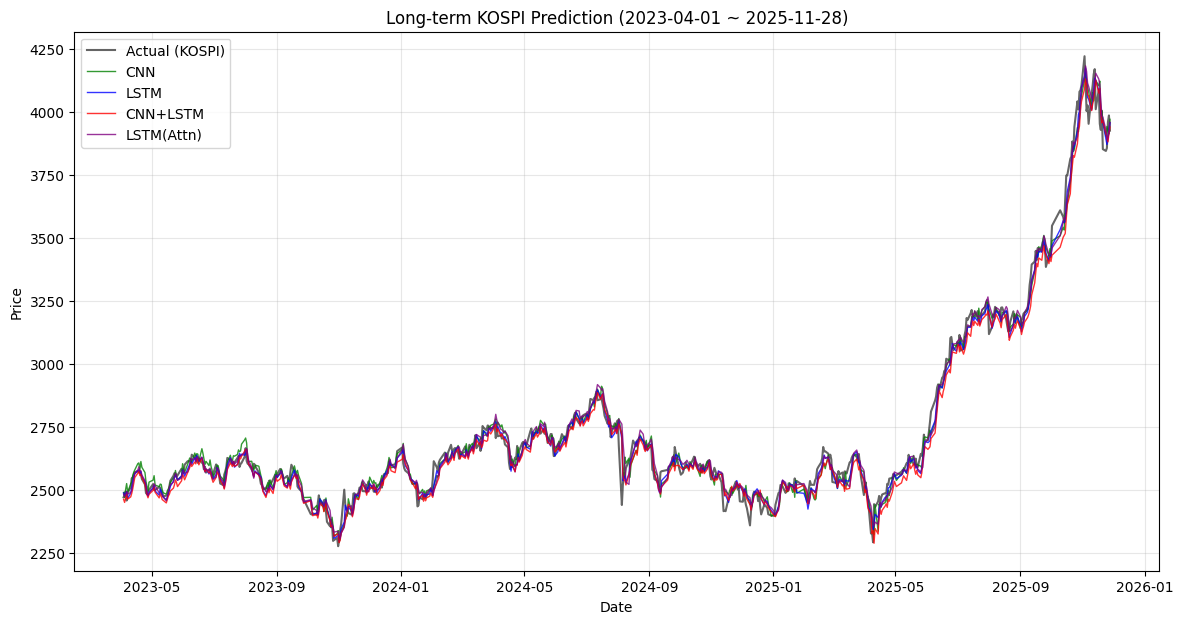

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# [수정] 폰트 설정: 코랩 기본 폰트(DejaVu Sans) 강제 지정하여 에러 방지
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",
    "train_cutoff_date": "2025-11-21", # 학습용 데이터 끝나는 날짜
    "test_start_date": "2025-11-24",   # RMSE 평가 시작 날짜
    "test_end_date": "2025-11-28",     # RMSE 평가 종료 날짜

    "plot_start_date": "2023-04-01",   # 그래프 그릴 시작 날짜

    "seq_length": 5,
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 50, # 실험 속도를 위해 50으로 설정 (필요시 100으로 증가)
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups Definition ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'],
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'], # Foreign_Rate는 csv 컬럼명 확인 필요
    "Future": ['Future_Close', 'Future_Change'],
    "Oil": ['WTI_Close', 'WTI_Change']
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings_to_try:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]

    return df

def process_features(df, drop_group_name=None):
    """특정 피처 그룹을 제거하고 데이터셋을 준비함"""

    target_col = "KOSPI_Close"

    # 전체 사용 가능한 피처 식별
    available_cols = df.columns.tolist()

    # 제거할 피처 목록 결정
    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        # 실제 데이터에 있는 것만 필터링
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]

    # [중요] 타겟 컬럼(KOSPI_Close)은 y생성을 위해 제거하면 안 됨.
    # 하지만 X(입력)에서는 제거 실험을 할 수 있음.
    # 여기서는 y데이터를 먼저 뽑고, X데이터프레임에서 제거하는 방식을 사용.

    # 1. Target Data 추출 (y)
    raw_y = df[[target_col]].values

    # 2. Input Features 구성 (X)
    # drop_group에 target_col이 포함되어 있어도 X에서는 제거, y는 유지
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    # Scaler
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    # Sequence Generation
    X, y = [], []
    seq_len = CONFIG["seq_length"]

    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0]) # Next step prediction

    X = np.array(X)
    y = np.array(y)

    # Dates alignment
    dates = df.index[seq_len:]

    return X, y, dates, scaler_y, len(input_df.columns)

def split_data(X, y, dates, config):
    # Split based on date
    train_end = pd.Timestamp(config["train_cutoff_date"])

    train_mask = dates <= train_end
    # Test data: Evaluation period (Nov 24 ~ Nov 28)
    test_start = pd.Timestamp(config["test_start_date"])
    test_end = pd.Timestamp(config["test_end_date"])
    test_mask = (dates >= test_start) & (dates <= test_end)

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    test_dates = dates[test_mask]

    # For long-term plotting
    plot_start = pd.Timestamp(config["plot_start_date"])
    plot_mask = dates >= plot_start
    X_plot = X[plot_mask]
    y_plot = y[plot_mask]
    plot_dates = dates[plot_mask]

    # To Tensor
    device = config['device']
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.FloatTensor(y_test).unsqueeze(1).to(device)
    X_plot_t = torch.FloatTensor(X_plot).to(device)

    return (X_train_t, y_train_t), (X_test_t, y_test_t, test_dates), (X_plot_t, y_plot, plot_dates)

# --- 3. Models ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training ---
def train_model(model, train_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            if torch.isnan(loss): return model # Fail safe
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config["patience"]: break
    return model

# --- 5. Main Logic ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)
    print(f"Data range: {full_df.index.min()} ~ {full_df.index.max()}")

    # 1. Ablation Study Scenarios
    scenarios = ["Base (All Features)"] + [f"Remove {g}" for g in FEATURE_GROUPS.keys()]

    results = [] # Store RMSE results
    best_rmse = float('inf')
    best_scenario = "Base (All Features)"

    # Store long-term predictions for plotting (only for base or best)
    long_term_preds = {}

    print("\n[Start Ablation Study]")

    for scenario in scenarios:
        drop_group = scenario.replace("Remove ", "") if "Remove" in scenario else None
        print(f"\n>> Experiment: {scenario}")

        # Prepare Data
        X, y, dates, scaler_y, input_dim = process_features(full_df, drop_group)
        train_data, test_data, plot_data = split_data(X, y, dates, CONFIG)

        train_loader = DataLoader(TensorDataset(*train_data), batch_size=CONFIG["batch_size"], shuffle=True)

        # Define Models [수정: LSTM Attention 추가]
        models = {
            "CNN": CNNModel(input_dim, 1, 32, 5, CONFIG["seq_length"]),
            "LSTM": LSTMModel(input_dim, 256, 1, 1),
            "CNN+LSTM": CNNLSTMModel(input_dim, 256, 1, 1, 32, 5),
            "LSTM(Attn)": LSTMAttentionModel(input_dim, 256, 1, 1)
        }

        scenario_rmse = {}

        for name, model in models.items():
            model.to(CONFIG['device'])
            train_model(model, train_loader, CONFIG)

            # Evaluate on Test (Nov 24 ~ Nov 28)
            model.eval()
            with torch.no_grad():
                pred_scaled = model(test_data[0]).cpu().numpy()
                y_true_scaled = test_data[1].cpu().numpy()

            pred_inv = scaler_y.inverse_transform(pred_scaled)
            y_true_inv = scaler_y.inverse_transform(y_true_scaled)

            rmse = np.sqrt(mean_squared_error(y_true_inv, pred_inv))
            scenario_rmse[name] = rmse
            print(f"   [{name}] RMSE: {rmse:.4f}")

            # Save predictions for Base scenario (to plot long term graph)
            if scenario == "Base (All Features)":
                model.eval()
                with torch.no_grad():
                    plot_pred_scaled = model(plot_data[0]).cpu().numpy()
                plot_pred_inv = scaler_y.inverse_transform(plot_pred_scaled)
                long_term_preds[name] = pd.Series(plot_pred_inv.flatten(), index=plot_data[2])

                # Save Actuals once
                if "Actual" not in long_term_preds:
                    y_plot_inv = scaler_y.inverse_transform(plot_data[1].reshape(-1,1))
                    long_term_preds["Actual"] = pd.Series(y_plot_inv.flatten(), index=plot_data[2])

        # Record Results
        row = {"Scenario": scenario}
        row.update(scenario_rmse)
        results.append(row)

    # --- 6. Results & Plotting ---
    print("\n[Ablation Study Results]")
    df_res = pd.DataFrame(results)
    print(df_res)
    df_res.to_csv("ablation_study_results.csv", index=False)

    # 2. Long-term Plotting (2023-04 ~ 2025-11-28)
    print("\n[Drawing Long-term Comparison Plot...]")
    plt.figure(figsize=(14, 7))

    # Actual
    plt.plot(long_term_preds["Actual"].index, long_term_preds["Actual"], label='Actual (KOSPI)', color='black', alpha=0.6, linewidth=1.5)

    # Models [수정: LSTM(Attn) 색상 추가]
    colors = {'CNN': 'green', 'LSTM': 'blue', 'CNN+LSTM': 'red', 'LSTM(Attn)': 'purple'}
    for name, pred_series in long_term_preds.items():
        if name == "Actual": continue
        plt.plot(pred_series.index, pred_series, label=name, color=colors.get(name, 'orange'), alpha=0.8, linewidth=1)

    plt.title(f"Long-term KOSPI Prediction ({CONFIG['plot_start_date']} ~ {CONFIG['data_end']})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig("long_term_prediction_comparison.png", dpi=300)
    print("Graph Saved: long_term_prediction_comparison.png")

if __name__ == "__main__":
    main()

#CNN feature remove graph

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# 폰트 설정: 코랩 기본 폰트(DejaVu Sans) 사용
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",
    "train_cutoff_date": "2025-11-21",
    "test_start_date": "2025-11-24",
    "test_end_date": "2025-11-28",

    "plot_start_date": "2023-04-01",

    "seq_length": 5,
    "predict_horizon": 5,

    # CNN Hyperparameters
    "num_classes": 1,
    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups Definition ---
FEATURE_GROUPS = {
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'], # 외인보유 묶음
    "Oil": ['WTI_Close', 'WTI_Change'],                                          # WTI 묶음
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'] # 나스닥 묶음
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings_to_try:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]

    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    # 제거할 피처 목록 결정
    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]

    # 1. Target Data (y)
    raw_y = df[[target_col]].values

    # 2. Input Features (X) - Drop specific group
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    X, y = [], []
    seq_len = CONFIG["seq_length"]

    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0])

    X = np.array(X)
    y = np.array(y)
    dates = df.index[seq_len:]

    return X, y, dates, scaler_y, len(input_df.columns)

def split_data(X, y, dates, config):
    train_end = pd.Timestamp(config["train_cutoff_date"])

    train_mask = dates <= train_end

    # Long-term plotting data
    plot_start = pd.Timestamp(config["plot_start_date"])
    plot_mask = dates >= plot_start
    X_plot = X[plot_mask]
    y_plot = y[plot_mask]
    plot_dates = dates[plot_mask]

    # Tensor conversion
    device = config['device']
    X_train_t = torch.FloatTensor(X[train_mask]).to(device)
    y_train_t = torch.FloatTensor(y[train_mask]).unsqueeze(1).to(device)
    X_plot_t = torch.FloatTensor(X_plot).to(device)

    return (X_train_t, y_train_t), (X_plot_t, y_plot, plot_dates)

# --- 3. CNN Model ---
class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

# --- 4. Training ---
def train_model(model, train_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config["patience"]: break
    return model

# --- 5. Plotting Function ---
def plot_individual_graph(scenario_name, dates, y_true, y_pred):
    plt.figure(figsize=(12, 6))

    # Actual
    plt.plot(dates, y_true, label='Actual (KOSPI)', color='black', alpha=0.5, linewidth=1.5)

    # Predicted
    plt.plot(dates, y_pred, label=f'CNN Prediction ({scenario_name})', color='red', alpha=0.8, linewidth=1.5)

    plt.title(f"CNN Analysis: {scenario_name} ({CONFIG['plot_start_date']} ~ {CONFIG['data_end']})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save file
    filename = f"CNN_Analysis_{scenario_name.replace(' ', '_')}.png"
    plt.savefig(filename, dpi=300)
    print(f"Graph Saved: {filename}")
    plt.close()

# --- 6. Main Logic ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # Target Scenarios
    scenarios_to_analyze = ["Foreign", "Oil", "NASDAQ"]

    print("\n[Start CNN Analysis by Feature Group]")

    for group_name in scenarios_to_analyze:
        scenario_label = f"Remove {group_name}"
        print(f"\n>> Analyzing Scenario: {scenario_label}")

        # 1. Process Data (Remove specific group)
        X, y, dates, scaler_y, input_dim = process_features(full_df, drop_group_name=group_name)
        train_data, plot_data = split_data(X, y, dates, CONFIG)

        train_loader = DataLoader(TensorDataset(*train_data), batch_size=CONFIG["batch_size"], shuffle=True)

        # 2. Initialize CNN Model
        model = CNNModel(input_dim, 1, CONFIG["num_filters"], CONFIG["kernel_size"], CONFIG["seq_length"])
        model.to(CONFIG['device'])

        # 3. Train
        train_model(model, train_loader, CONFIG)

        # 4. Predict Long-term
        model.eval()
        with torch.no_grad():
            pred_scaled = model(plot_data[0]).cpu().numpy()
            y_true_scaled = plot_data[1].reshape(-1, 1)

        pred_inv = scaler_y.inverse_transform(pred_scaled).flatten()
        y_true_inv = scaler_y.inverse_transform(y_true_scaled).flatten()

        # 5. Plot & Save
        plot_dates = plot_data[2]
        plot_individual_graph(scenario_label, plot_dates, y_true_inv, pred_inv)

    print("\nAll graphs generated successfully.")

if __name__ == "__main__":
    main()

Using Device: cuda
Loading Data...

[Start CNN Analysis by Feature Group]

>> Analyzing Scenario: Remove Foreign
Graph Saved: CNN_Analysis_Remove_Foreign.png

>> Analyzing Scenario: Remove Oil
Graph Saved: CNN_Analysis_Remove_Oil.png

>> Analyzing Scenario: Remove NASDAQ
Graph Saved: CNN_Analysis_Remove_NASDAQ.png

All graphs generated successfully.


##LSTM feature remove graph

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# 폰트 설정: 코랩 기본 폰트(DejaVu Sans) 사용
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",
    "train_cutoff_date": "2025-11-21",

    # 그래프를 그릴 시작 날짜 (장기 추세 확인용)
    "plot_start_date": "2023-04-01",

    "seq_length": 5,
    "predict_horizon": 5,

    # LSTM Hyperparameters
    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups Definition ---
FEATURE_GROUPS = {
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'], # 나스닥 묶음
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change']                                             # VKOSPI 묶음
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings_to_try:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]

    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    # 제거할 피처 목록 결정
    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]

    # 1. Target Data (y)
    raw_y = df[[target_col]].values

    # 2. Input Features (X) - Drop specific group
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    X, y = [], []
    seq_len = CONFIG["seq_length"]

    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0])

    X = np.array(X)
    y = np.array(y)
    dates = df.index[seq_len:]

    return X, y, dates, scaler_y, len(input_df.columns)

def split_data(X, y, dates, config):
    train_end = pd.Timestamp(config["train_cutoff_date"])

    train_mask = dates <= train_end

    # Long-term plotting data
    plot_start = pd.Timestamp(config["plot_start_date"])
    plot_mask = dates >= plot_start
    X_plot = X[plot_mask]
    y_plot = y[plot_mask]
    plot_dates = dates[plot_mask]

    # Tensor conversion
    device = config['device']
    X_train_t = torch.FloatTensor(X[train_mask]).to(device)
    y_train_t = torch.FloatTensor(y[train_mask]).unsqueeze(1).to(device)
    X_plot_t = torch.FloatTensor(X_plot).to(device)

    return (X_train_t, y_train_t), (X_plot_t, y_plot, plot_dates)

# --- 3. LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# --- 4. Training ---
def train_model(model, train_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config["patience"]: break
    return model

# --- 5. Plotting Function ---
def plot_individual_graph(scenario_label, dates, y_true, y_pred):
    plt.figure(figsize=(12, 6))

    # Actual
    plt.plot(dates, y_true, label='Actual (KOSPI)', color='blue', alpha=0.5, linewidth=1.5)

    # Predicted
    plt.plot(dates, y_pred, label=f'LSTM Prediction ({scenario_label})', color='red', alpha=0.8, linewidth=1.5)

    plt.title(f"LSTM Analysis: {scenario_label} ({CONFIG['plot_start_date']} ~ {CONFIG['data_end']})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save file
    filename = f"LSTM_Analysis_{scenario_label.replace(' ', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(filename, dpi=300)
    print(f"Graph Saved: {filename}")
    plt.close()

# --- 6. Main Logic ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # Target Scenarios for LSTM
    # (Label Name, Drop Group Name)
    scenarios = [
        ("Base (All Features)", None),      # 1순위: All Features
        ("Remove NASDAQ", "NASDAQ"),        # 2순위: Remove NASDAQ
        ("Remove VKOSPI", "VKOSPI")         # 3순위: Remove VKOSPI
    ]

    print("\n[Start LSTM Analysis by Feature Group]")

    for label, drop_group in scenarios:
        print(f"\n>> Analyzing Scenario: {label}")

        # 1. Process Data (Remove specific group)
        X, y, dates, scaler_y, input_dim = process_features(full_df, drop_group_name=drop_group)
        train_data, plot_data = split_data(X, y, dates, CONFIG)

        train_loader = DataLoader(TensorDataset(*train_data), batch_size=CONFIG["batch_size"], shuffle=True)

        # 2. Initialize LSTM Model
        model = LSTMModel(input_dim, CONFIG["hidden_size"], CONFIG["num_layers"], CONFIG["num_classes"])
        model.to(CONFIG['device'])

        # 3. Train
        train_model(model, train_loader, CONFIG)

        # 4. Predict Long-term
        model.eval()
        with torch.no_grad():
            pred_scaled = model(plot_data[0]).cpu().numpy()
            y_true_scaled = plot_data[1].reshape(-1, 1)

        pred_inv = scaler_y.inverse_transform(pred_scaled).flatten()
        y_true_inv = scaler_y.inverse_transform(y_true_scaled).flatten()

        # 5. Plot & Save
        plot_dates = plot_data[2]
        plot_individual_graph(label, plot_dates, y_true_inv, pred_inv)

    print("\nAll LSTM graphs generated successfully.")

if __name__ == "__main__":
    main()

Using Device: cpu
Loading Data...

[Start LSTM Analysis by Feature Group]

>> Analyzing Scenario: Base (All Features)
Graph Saved: LSTM_Analysis_Base_All_Features.png

>> Analyzing Scenario: Remove NASDAQ
Graph Saved: LSTM_Analysis_Remove_NASDAQ.png

>> Analyzing Scenario: Remove VKOSPI
Graph Saved: LSTM_Analysis_Remove_VKOSPI.png

All LSTM graphs generated successfully.


##CNN+LSTM feature remove test

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# 폰트 설정: 코랩 기본 폰트(DejaVu Sans) 사용
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. 설정 (Configuration) ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",
    "train_cutoff_date": "2025-11-21",

    "plot_start_date": "2023-04-01",

    "seq_length": 5,
    "predict_horizon": 5,

    # CNN+LSTM 하이퍼파라미터
    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,
    "num_filters": 32,   # CNN 필터 수
    "kernel_size": 5,    # CNN 커널 크기

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- 피처 그룹 정의 ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],                                   # 금리/환율 묶음
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'] # 나스닥 묶음
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. 데이터 처리 함수 ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings_to_try:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]

    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]
        # 타겟 컬럼(KOSPI_Close)은 y데이터 생성을 위해 필요하므로 cols_to_drop에서 제외
        if target_col in cols_to_drop:
             cols_to_drop.remove(target_col)

    raw_y = df[[target_col]].values
    # 입력 데이터(X)에서는 해당 그룹 피처를 모두 제거 (타겟 컬럼 제외)
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    X, y = [], []
    seq_len = CONFIG["seq_length"]

    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0])

    X = np.array(X)
    y = np.array(y)
    dates = df.index[seq_len:]

    return X, y, dates, scaler_y, len(input_df.columns)

def split_data(X, y, dates, config):
    train_end = pd.Timestamp(config["train_cutoff_date"])
    train_mask = dates <= train_end

    plot_start = pd.Timestamp(config["plot_start_date"])
    plot_mask = dates >= plot_start
    X_plot = X[plot_mask]
    y_plot = y[plot_mask]
    plot_dates = dates[plot_mask]

    device = config['device']
    X_train_t = torch.FloatTensor(X[train_mask]).to(device)
    y_train_t = torch.FloatTensor(y[train_mask]).unsqueeze(1).to(device)
    X_plot_t = torch.FloatTensor(X_plot).to(device)

    return (X_train_t, y_train_t), (X_plot_t, y_plot, plot_dates)

# --- 3. CNN+LSTM 모델 정의 ---
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        # CNN Layer
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size, padding='same')
        self.relu = nn.ReLU()
        # LSTM Layer
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (Batch, Seq, Feat)
        # Conv1d expects: (Batch, Channel/Feat, Seq)
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        # LSTM expects: (Batch, Seq, Feat)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# --- 4. 학습 함수 ---
def train_model(model, train_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config["patience"]: break
    return model

# --- 5. 그래프 그리기 함수 ---
def plot_individual_graph(scenario_label, dates, y_true, y_pred):
    plt.figure(figsize=(12, 6))

    # 실제값
    plt.plot(dates, y_true, label='Actual (KOSPI)', color='blue', alpha=0.5, linewidth=1.5)

    # 예측값 (CNN+LSTM)
    plt.plot(dates, y_pred, label=f'CNN+LSTM Prediction ({scenario_label})', color='red', alpha=0.8, linewidth=1.5)

    plt.title(f"CNN+LSTM Analysis: {scenario_label} ({CONFIG['plot_start_date']} ~ {CONFIG['data_end']})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 파일 저장
    filename = f"CNNLSTM_Analysis_{scenario_label.replace(' ', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(filename, dpi=300)
    print(f"Graph Saved: {filename}")
    plt.close()

# --- 6. 메인 실행 ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # 분석 시나리오 설정 (Label Name, Drop Group Name)
    scenarios = [
        ("Remove KOSPI", "KOSPI"),          # 1순위: KOSPI 제거
        ("Remove Rate & FX", "Rate_FX"),    # 2순위: 금리/환율 제거
        ("Remove NASDAQ", "NASDAQ")         # 3순위: 나스닥 제거
    ]

    print("\n[Start CNN+LSTM Analysis by Feature Group]")

    for label, drop_group in scenarios:
        print(f"\n>> Analyzing Scenario: {label}")

        # 1. 데이터 준비
        X, y, dates, scaler_y, input_dim = process_features(full_df, drop_group_name=drop_group)
        train_data, plot_data = split_data(X, y, dates, CONFIG)

        train_loader = DataLoader(TensorDataset(*train_data), batch_size=CONFIG["batch_size"], shuffle=True)

        # 2. 모델 초기화 (CNN+LSTM)
        model = CNNLSTMModel(
            input_size=input_dim,
            hidden_size=CONFIG["hidden_size"],
            num_layers=CONFIG["num_layers"],
            output_size=CONFIG["num_classes"],
            num_filters=CONFIG["num_filters"],
            kernel_size=CONFIG["kernel_size"]
        )
        model.to(CONFIG['device'])

        # 3. 학습
        train_model(model, train_loader, CONFIG)

        # 4. 장기 예측
        model.eval()
        with torch.no_grad():
            pred_scaled = model(plot_data[0]).cpu().numpy()
            y_true_scaled = plot_data[1].reshape(-1, 1)

        pred_inv = scaler_y.inverse_transform(pred_scaled).flatten()
        y_true_inv = scaler_y.inverse_transform(y_true_scaled).flatten()

        # 5. 그래프 저장
        plot_dates = plot_data[2]
        plot_individual_graph(label, plot_dates, y_true_inv, pred_inv)

    print("\nAll CNN+LSTM graphs generated successfully.")

if __name__ == "__main__":
    main()

Using Device: cpu
Loading Data...

[Start CNN+LSTM Analysis by Feature Group]

>> Analyzing Scenario: Remove KOSPI
Graph Saved: CNNLSTM_Analysis_Remove_KOSPI.png

>> Analyzing Scenario: Remove Rate & FX
Graph Saved: CNNLSTM_Analysis_Remove_Rate_&_FX.png

>> Analyzing Scenario: Remove NASDAQ
Graph Saved: CNNLSTM_Analysis_Remove_NASDAQ.png

All CNN+LSTM graphs generated successfully.


##Attention 적용 모델

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# 폰트 설정: 코랩 기본 폰트(DejaVu Sans) 사용
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. 설정 (Configuration) ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",
    "train_cutoff_date": "2025-11-21",

    "plot_start_date": "2023-04-01",

    "seq_length": 5,
    "predict_horizon": 5,

    # LSTM Attention 하이퍼파라미터
    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- 피처 그룹 정의 ---
FEATURE_GROUPS = {
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'], # 외인 비율/자본 묶음
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],                                 # VKOSPI 묶음
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'] # (참고용)
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. 데이터 처리 함수 ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings_to_try:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]

    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]

    raw_y = df[[target_col]].values
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    X, y = [], []
    seq_len = CONFIG["seq_length"]

    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0])

    X = np.array(X)
    y = np.array(y)
    dates = df.index[seq_len:]

    return X, y, dates, scaler_y, len(input_df.columns)

def split_data(X, y, dates, config):
    train_end = pd.Timestamp(config["train_cutoff_date"])
    train_mask = dates <= train_end

    plot_start = pd.Timestamp(config["plot_start_date"])
    plot_mask = dates >= plot_start
    X_plot = X[plot_mask]
    y_plot = y[plot_mask]
    plot_dates = dates[plot_mask]

    device = config['device']
    X_train_t = torch.FloatTensor(X[train_mask]).to(device)
    y_train_t = torch.FloatTensor(y[train_mask]).unsqueeze(1).to(device)
    X_plot_t = torch.FloatTensor(X_plot).to(device)

    return (X_train_t, y_train_t), (X_plot_t, y_plot, plot_dates)

# --- 3. LSTM Attention 모델 정의 ---
class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Attention Layer
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (Batch, Seq, Feat)
        out, _ = self.lstm(x) # out: (Batch, Seq, Hidden)

        # Attention Score
        attn_weights = torch.softmax(self.attention(out), dim=1) # (Batch, Seq, 1)

        # Context Vector (Weighted Sum)
        context = torch.sum(attn_weights * out, dim=1) # (Batch, Hidden)

        output = self.fc(context)
        return output

# --- 4. 학습 함수 ---
def train_model(model, train_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config["patience"]: break
    return model

# --- 5. 그래프 그리기 함수 ---
def plot_individual_graph(scenario_label, dates, y_true, y_pred):
    plt.figure(figsize=(12, 6))

    # 실제값
    plt.plot(dates, y_true, label='Actual (KOSPI)', color='blue', alpha=0.5, linewidth=1.5)

    # 예측값 (LSTM Attention - 보라색)
    plt.plot(dates, y_pred, label=f'LSTM(Attn) Prediction ({scenario_label})', color='red', alpha=0.8, linewidth=1.5)

    plt.title(f"LSTM Attention Analysis: {scenario_label} ({CONFIG['plot_start_date']} ~ {CONFIG['data_end']})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 파일 저장
    filename = f"LSTMAttn_Analysis_{scenario_label.replace(' ', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(filename, dpi=300)
    print(f"Graph Saved: {filename}")
    plt.close()

# --- 6. 메인 실행 ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # 분석 시나리오 설정 (Label Name, Drop Group Name)
    scenarios = [
        ("Remove Foreign", "Foreign"),      # 1순위: 외인 제거
        ("Base (All Features)", None),      # 2순위: 전체 피처
        ("Remove VKOSPI", "VKOSPI")         # 3순위: VKOSPI 제거
    ]

    print("\n[Start LSTM Attention Analysis by Feature Group]")

    for label, drop_group in scenarios:
        print(f"\n>> Analyzing Scenario: {label}")

        # 1. 데이터 준비
        X, y, dates, scaler_y, input_dim = process_features(full_df, drop_group_name=drop_group)
        train_data, plot_data = split_data(X, y, dates, CONFIG)

        train_loader = DataLoader(TensorDataset(*train_data), batch_size=CONFIG["batch_size"], shuffle=True)

        # 2. 모델 초기화 (LSTM Attention)
        model = LSTMAttentionModel(
            input_size=input_dim,
            hidden_size=CONFIG["hidden_size"],
            num_layers=CONFIG["num_layers"],
            output_size=CONFIG["num_classes"]
        )
        model.to(CONFIG['device'])

        # 3. 학습
        train_model(model, train_loader, CONFIG)

        # 4. 장기 예측
        model.eval()
        with torch.no_grad():
            pred_scaled = model(plot_data[0]).cpu().numpy()
            y_true_scaled = plot_data[1].reshape(-1, 1)

        pred_inv = scaler_y.inverse_transform(pred_scaled).flatten()
        y_true_inv = scaler_y.inverse_transform(y_true_scaled).flatten()

        # 5. 그래프 저장
        plot_dates = plot_data[2]
        plot_individual_graph(label, plot_dates, y_true_inv, pred_inv)

    print("\nAll LSTM Attention graphs generated successfully.")

if __name__ == "__main__":
    main()

Using Device: cpu
Loading Data...

[Start LSTM Attention Analysis by Feature Group]

>> Analyzing Scenario: Remove Foreign
Graph Saved: LSTMAttn_Analysis_Remove_Foreign.png

>> Analyzing Scenario: Base (All Features)
Graph Saved: LSTMAttn_Analysis_Base_All_Features.png

>> Analyzing Scenario: Remove VKOSPI
Graph Saved: LSTMAttn_Analysis_Remove_VKOSPI.png

All LSTM Attention graphs generated successfully.


## 4가지 모델 all feature RMSE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# 폰트 설정: 코랩 기본 폰트(DejaVu Sans) 강제 지정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",
    "train_cutoff_date": "2025-11-21",
    "test_start_date": "2025-11-24",
    "test_end_date": "2025-11-28",

    "plot_start_date": "2023-04-01",

    "seq_length": 5,
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups Definition ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'],
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'],
    "Future": ['Future_Close', 'Future_Change'],
    "Oil": ['WTI_Close', 'WTI_Change']
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings_to_try:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]

    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]

    raw_y = df[[target_col]].values
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    X, y = [], []
    seq_len = CONFIG["seq_length"]

    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0])

    X = np.array(X)
    y = np.array(y)
    dates = df.index[seq_len:]

    return X, y, dates, scaler_y, len(input_df.columns)

def split_data(X, y, dates, config):
    train_end = pd.Timestamp(config["train_cutoff_date"])
    train_mask = dates <= train_end

    test_start = pd.Timestamp(config["test_start_date"])
    test_end = pd.Timestamp(config["test_end_date"])
    test_mask = (dates >= test_start) & (dates <= test_end)

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    test_dates = dates[test_mask]

    plot_start = pd.Timestamp(config["plot_start_date"])
    plot_mask = dates >= plot_start
    X_plot = X[plot_mask]
    y_plot = y[plot_mask]
    plot_dates = dates[plot_mask]

    device = config['device']
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.FloatTensor(y_test).unsqueeze(1).to(device)
    X_plot_t = torch.FloatTensor(X_plot).to(device)

    return (X_train_t, y_train_t), (X_test_t, y_test_t, test_dates), (X_plot_t, y_plot, plot_dates)

# --- 3. Models ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training ---
def train_model(model, train_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            if torch.isnan(loss): return model
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config["patience"]: break
    return model

# --- 5. Main Logic ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)
    print(f"Data range: {full_df.index.min()} ~ {full_df.index.max()}")

    # [설정] 그래프를 그리기 위해 'Base (All Features)' 시나리오만 기본 실행
    # (전체 Ablation 실험을 원하면 아래 주석을 해제하고 scenarios 리스트를 확장하세요)
    scenarios = ["Base (All Features)"]
    # scenarios = ["Base (All Features)"] + [f"Remove {g}" for g in FEATURE_GROUPS.keys()]

    results = []
    long_term_preds = {}

    print("\n[Start Training & Prediction]")

    for scenario in scenarios:
        drop_group = scenario.replace("Remove ", "") if "Remove" in scenario else None
        print(f"\n>> Scenario: {scenario}")

        X, y, dates, scaler_y, input_dim = process_features(full_df, drop_group)
        train_data, test_data, plot_data = split_data(X, y, dates, CONFIG)

        train_loader = DataLoader(TensorDataset(*train_data), batch_size=CONFIG["batch_size"], shuffle=True)

        models = {
            "CNN": CNNModel(input_dim, 1, 32, 5, CONFIG["seq_length"]),
            "LSTM": LSTMModel(input_dim, 256, 1, 1),
            "CNN+LSTM": CNNLSTMModel(input_dim, 256, 1, 1, 32, 5),
            "LSTM(Attn)": LSTMAttentionModel(input_dim, 256, 1, 1)
        }

        scenario_rmse = {}

        for name, model in models.items():
            print(f"   Training {name}...")
            model.to(CONFIG['device'])
            train_model(model, train_loader, CONFIG)

            # 1. Test RMSE Calculation
            model.eval()
            with torch.no_grad():
                pred_scaled = model(test_data[0]).cpu().numpy()
                y_true_scaled = test_data[1].cpu().numpy()

            pred_inv = scaler_y.inverse_transform(pred_scaled)
            y_true_inv = scaler_y.inverse_transform(y_true_scaled)

            rmse = np.sqrt(mean_squared_error(y_true_inv, pred_inv))
            scenario_rmse[name] = rmse
            print(f"     -> RMSE: {rmse:.4f}")

            # 2. Long-term Prediction (Only for Base scenario)
            if scenario == "Base (All Features)":
                model.eval()
                with torch.no_grad():
                    plot_pred_scaled = model(plot_data[0]).cpu().numpy()
                plot_pred_inv = scaler_y.inverse_transform(plot_pred_scaled)
                long_term_preds[name] = pd.Series(plot_pred_inv.flatten(), index=plot_data[2])

                if "Actual" not in long_term_preds:
                    y_plot_inv = scaler_y.inverse_transform(plot_data[1].reshape(-1,1))
                    long_term_preds["Actual"] = pd.Series(y_plot_inv.flatten(), index=plot_data[2])

        row = {"Scenario": scenario}
        row.update(scenario_rmse)
        results.append(row)

    # --- 6. Results & Individual Plotting ---
    print("\n[Results Summary]")
    df_res = pd.DataFrame(results)
    print(df_res)
    df_res.to_csv("ablation_study_results.csv", index=False)

    # [수정] 모델별 개별 그래프 그리기
    print("\n[Drawing Individual Graphs for Base Scenario...]")

    if "Actual" in long_term_preds:
        actual_data = long_term_preds["Actual"]

        for name, pred_series in long_term_preds.items():
            if name == "Actual": continue

            plt.figure(figsize=(14, 7))

            # Actual (Black line)
            plt.plot(actual_data.index, actual_data, label='Actual (KOSPI)', color='black', alpha=0.5, linewidth=1.5)

            # Predicted (Red line)
            plt.plot(pred_series.index, pred_series, label=f'Predicted ({name})', color='red', alpha=0.8, linewidth=1.5)

            plt.title(f"Long-term Prediction: {name} (All Features)")
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Filename formatting
            safe_name = name.replace('(', '').replace(')', '').replace('+', '_')
            fname = f"LongTerm_Prediction_{safe_name}.png"

            plt.savefig(fname, dpi=300)
            print(f"Saved graph: {fname}")
            plt.close()

if __name__ == "__main__":
    main()

Using Device: cuda
Loading Data...
Data range: 2013-08-06 00:00:00 ~ 2025-11-28 00:00:00

[Start Training & Prediction]

>> Scenario: Base (All Features)
   Training CNN...
     -> RMSE: 49.0156
   Training LSTM...
     -> RMSE: 51.9183
   Training CNN+LSTM...
     -> RMSE: 62.3512
   Training LSTM(Attn)...
     -> RMSE: 62.5916

[Results Summary]
              Scenario        CNN       LSTM   CNN+LSTM  LSTM(Attn)
0  Base (All Features)  49.015583  51.918318  62.351239   62.591593

[Drawing Individual Graphs for Base Scenario...]
Saved graph: LongTerm_Prediction_CNN.png
Saved graph: LongTerm_Prediction_LSTM.png
Saved graph: LongTerm_Prediction_CNN_LSTM.png
Saved graph: LongTerm_Prediction_LSTMAttn.png


##Each optimized model plotting

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# 폰트 설정 (코랩/영문 환경 호환)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",

    # 검증 대상 기간 (Actual vs Predicted 비교용)
    "test_start_date": "2025-11-24",
    "test_end_date": "2025-11-28",

    "seq_length": 5,
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'],
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'],
    "Future": ['Future_Close', 'Future_Change'],
    "Oil": ['WTI_Close', 'WTI_Change']
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing Utils ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]
    return df

def process_features_and_split(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]
        if target_col in cols_to_drop:
             cols_to_drop.remove(target_col)

    # 1. Target (y)
    raw_y = df[[target_col]].values

    # 2. Input (X)
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    X, y = [], []
    seq_len = CONFIG["seq_length"]

    # 시퀀스 데이터 생성
    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0]) # 다음 스텝(1일 뒤) 예측 학습용

    X = np.array(X)
    y = np.array(y)

    # 날짜 매핑 (예측 대상 날짜 기준)
    dates = df.index[seq_len:]

    # Split Train/Test based on Date
    test_start = pd.Timestamp(CONFIG["test_start_date"])
    test_end = pd.Timestamp(CONFIG["test_end_date"])

    # 학습 데이터: 테스트 시작일 이전
    train_mask = dates < test_start
    # 테스트 데이터: 지정된 기간 (11/24 ~ 11/28)
    test_mask = (dates >= test_start) & (dates <= test_end)

    X_train = X[train_mask]
    y_train = y[train_mask]

    X_test = X[test_mask]
    # 실제값 (Graph용)
    y_test_raw = raw_y[seq_len:][test_mask]
    test_dates = dates[test_mask]

    return X_train, y_train, X_test, y_test_raw, test_dates, scaler_y, len(input_df.columns)

# --- 3. Models ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training ---
def train_model(model, X_train, y_train, config):
    X_t = torch.FloatTensor(X_train).to(config['device'])
    y_t = torch.FloatTensor(y_train).unsqueeze(1).to(config['device'])

    dataset = TensorDataset(X_t, y_t)
    loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    for epoch in range(config["epochs"]):
        for X_b, y_b in loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
    return model

# --- 5. Plotting Function (No numbers, Date only) ---
def plot_comparison(model_name, drop_group, dates, y_true, y_pred):
    plt.figure(figsize=(10, 6))

    # Actual (Blue, Solid)
    plt.plot(dates, y_true, label='Actual', color='blue', marker='o', linewidth=2)

    # Predicted (Red, Dashed)
    plt.plot(dates, y_pred, label='Predicted', color='red', linestyle='--', marker='x', linewidth=2)

    # Styling
    title_str = f"{model_name} Prediction (Optimized: Drop {drop_group if drop_group else 'None'})"
    plt.title(title_str, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("KOSPI Index", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # [수정] X축 날짜 포맷 설정 (YYYY-MM-DD, 시간 제거)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator()) # 매일 표시
    plt.gcf().autofmt_xdate() # 날짜 겹침 방지 (회전)

    # [수정] 숫자 어노테이션 제거됨 (No plt.text)

    # Save
    safe_name = model_name.replace('+', '_').replace('(', '').replace(')', '')
    filename = f"Evaluation_{safe_name}.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"   [Graph Saved] {filename}")
    plt.close()

# --- 6. Main Logic ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # Optimized Scenarios
    scenarios = [
        ("CNN", "Foreign", CNNModel),
        ("LSTM", None, LSTMModel),
        ("CNN+LSTM", "KOSPI", CNNLSTMModel),
        ("LSTM(Attn)", "Foreign", LSTMAttentionModel)
    ]

    print(f"\n[Start Evaluation] Target Period: {CONFIG['test_start_date']} ~ {CONFIG['test_end_date']}")

    for model_name, drop_group, ModelClass in scenarios:
        print(f"\n>> Processing {model_name} (Drop: {drop_group})...")

        # 1. Prepare Data & Split
        X_train, y_train, X_test, y_test_raw, test_dates, scaler_y, input_dim = \
            process_features_and_split(full_df, drop_group)

        if len(X_test) == 0:
            print("   [Error] No test data found. Check date range.")
            continue

        # 2. Init Model
        if model_name == "CNN":
            model = ModelClass(input_dim, 1, 32, 5, CONFIG["seq_length"])
        elif model_name == "CNN+LSTM":
            model = ModelClass(input_dim, 256, 1, 1, 32, 5)
        else:
            model = ModelClass(input_dim, 256, 1, 1)

        model.to(CONFIG['device'])

        # 3. Train
        model = train_model(model, X_train, y_train, CONFIG)

        # 4. Predict
        model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(X_test).to(CONFIG['device'])
            pred_scaled = model(input_tensor).cpu().numpy()

        # 5. Inverse Transform
        pred_prices = scaler_y.inverse_transform(pred_scaled).flatten()
        y_true_prices = y_test_raw.flatten()

        # 6. Draw & Save Graph (Clean version)
        plot_comparison(model_name, drop_group, test_dates, y_true_prices, pred_prices)

    print("\nAll evaluation graphs generated.")

if __name__ == "__main__":
    main()

Using Device: cpu
Loading Data...

[Start Evaluation] Target Period: 2025-11-24 ~ 2025-11-28

>> Processing CNN (Drop: Foreign)...
   [Graph Saved] Evaluation_CNN.png

>> Processing LSTM (Drop: None)...
   [Graph Saved] Evaluation_LSTM.png

>> Processing CNN+LSTM (Drop: KOSPI)...
   [Graph Saved] Evaluation_CNN_LSTM.png

>> Processing LSTM(Attn) (Drop: Foreign)...
   [Graph Saved] Evaluation_LSTMAttn.png

All evaluation graphs generated.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# 폰트 설정 (코랩/영문 환경 호환)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",

    # 검증 대상 기간 (Actual vs Predicted 비교용)
    "test_start_date": "2025-11-24",
    "test_end_date": "2025-11-28",

    "seq_length": 5,
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'],
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'],
    "Future": ['Future_Close', 'Future_Change'],
    "Oil": ['WTI_Close', 'WTI_Change']
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing Utils ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]
    return df

def process_features_and_split(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]
        if target_col in cols_to_drop:
             cols_to_drop.remove(target_col)

    # 1. Target (y)
    raw_y = df[[target_col]].values

    # 2. Input (X)
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    X, y = [], []
    seq_len = CONFIG["seq_length"]

    # 시퀀스 데이터 생성
    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0]) # 다음 스텝(1일 뒤) 예측 학습용

    X = np.array(X)
    y = np.array(y)

    # 날짜 매핑 (예측 대상 날짜 기준)
    dates = df.index[seq_len:]

    # Split Train/Test based on Date
    test_start = pd.Timestamp(CONFIG["test_start_date"])
    test_end = pd.Timestamp(CONFIG["test_end_date"])

    # 학습 데이터: 테스트 시작일 이전
    train_mask = dates < test_start
    # 테스트 데이터: 지정된 기간 (11/24 ~ 11/28)
    test_mask = (dates >= test_start) & (dates <= test_end)

    X_train = X[train_mask]
    y_train = y[train_mask]

    X_test = X[test_mask]
    # 실제값 (Graph용)
    y_test_raw = raw_y[seq_len:][test_mask]
    test_dates = dates[test_mask]

    return X_train, y_train, X_test, y_test_raw, test_dates, scaler_y, len(input_df.columns)

# --- 3. Models ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training ---
def train_model(model, X_train, y_train, config):
    X_t = torch.FloatTensor(X_train).to(config['device'])
    y_t = torch.FloatTensor(y_train).unsqueeze(1).to(config['device'])

    dataset = TensorDataset(X_t, y_t)
    loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    for epoch in range(config["epochs"]):
        for X_b, y_b in loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
    return model

# --- 5. Plotting Function (Modified) ---
def plot_comparison(model_name, drop_group, dates, y_true, y_pred, rmse):
    plt.figure(figsize=(10, 6))

    # Actual (Blue, Solid)
    plt.plot(dates, y_true, label='Actual', color='blue', marker='o', linewidth=2)

    # Predicted (Red, Dashed)
    plt.plot(dates, y_pred, label='Predicted', color='red', linestyle='--', marker='x', linewidth=2)

    # Styling - Clean Look + RMSE in title
    title_str = f"{model_name} Prediction (Optimized: Drop {drop_group if drop_group else 'None'})\nRMSE: {rmse:.4f}"
    plt.title(title_str, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("KOSPI Index", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # X축 날짜 포맷 설정 (YYYY-MM-DD, 시간 제거)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator()) # 매일 표시
    plt.gcf().autofmt_xdate() # 날짜 겹침 방지 (회전)

    # Save
    safe_name = model_name.replace('+', '_').replace('(', '').replace(')', '')
    filename = f"Evaluation_{safe_name}.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"   [Graph Saved] {filename}")
    plt.close()

# --- 6. Main Logic ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # Optimized Scenarios
    scenarios = [
        ("CNN", "Foreign", CNNModel),
        ("LSTM", None, LSTMModel),
        ("CNN+LSTM", "KOSPI", CNNLSTMModel),
        ("LSTM(Attn)", "Foreign", LSTMAttentionModel)
    ]

    print(f"\n[Start Evaluation] Target Period: {CONFIG['test_start_date']} ~ {CONFIG['test_end_date']}")

    rmse_results = []

    for model_name, drop_group, ModelClass in scenarios:
        print(f"\n>> Processing {model_name} (Drop: {drop_group})...")

        # 1. Prepare Data & Split
        X_train, y_train, X_test, y_test_raw, test_dates, scaler_y, input_dim = \
            process_features_and_split(full_df, drop_group)

        if len(X_test) == 0:
            print("   [Error] No test data found. Check date range.")
            continue

        # 2. Init Model
        if model_name == "CNN":
            model = ModelClass(input_dim, 1, 32, 5, CONFIG["seq_length"])
        elif model_name == "CNN+LSTM":
            model = ModelClass(input_dim, 256, 1, 1, 32, 5)
        else:
            model = ModelClass(input_dim, 256, 1, 1)

        model.to(CONFIG['device'])

        # 3. Train
        model = train_model(model, X_train, y_train, CONFIG)

        # 4. Predict
        model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(X_test).to(CONFIG['device'])
            pred_scaled = model(input_tensor).cpu().numpy()

        # 5. Inverse Transform & RMSE Calc
        pred_prices = scaler_y.inverse_transform(pred_scaled).flatten()
        y_true_prices = y_test_raw.flatten()

        # RMSE 계산 (scikit-learn의 mean_squared_error 사용 없이 직접 계산)
        rmse = np.sqrt(np.mean((y_true_prices - pred_prices) ** 2))
        rmse_results.append({"Model": model_name, "RMSE": rmse})
        print(f"   [Result] RMSE: {rmse:.4f}")

        # 6. Draw & Save Graph (Clean version with RMSE in title)
        plot_comparison(model_name, drop_group, test_dates, y_true_prices, pred_prices, rmse)

    print("\n[RMSE Summary]")
    rmse_df = pd.DataFrame(rmse_results)
    print(rmse_df)

    print("\nAll evaluation graphs generated.")

if __name__ == "__main__":
    main()

Using Device: cpu
Loading Data...

[Start Evaluation] Target Period: 2025-11-24 ~ 2025-11-28

>> Processing CNN (Drop: Foreign)...
   [Result] RMSE: 72.8049
   [Graph Saved] Evaluation_CNN.png

>> Processing LSTM (Drop: None)...
   [Result] RMSE: 47.8446
   [Graph Saved] Evaluation_LSTM.png

>> Processing CNN+LSTM (Drop: KOSPI)...
   [Result] RMSE: 48.5979
   [Graph Saved] Evaluation_CNN_LSTM.png

>> Processing LSTM(Attn) (Drop: Foreign)...
   [Result] RMSE: 71.2455
   [Graph Saved] Evaluation_LSTMAttn.png

[RMSE Summary]
        Model       RMSE
0         CNN  72.804859
1        LSTM  47.844604
2    CNN+LSTM  48.597881
3  LSTM(Attn)  71.245487

All evaluation graphs generated.


In [9]:
## 컬럼 수정본 11/28일부터 그래프 그려서 실패
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# 폰트 설정 (코랩/영문 환경 호환)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    # 11월 28일까지 데이터를 꽉 채워서 학습
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",

    # 예측 대상 (12월 1일 ~ 5일)
    "future_start_date": "2025-12-01",
    "future_days": 5,

    "seq_length": 5,
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'],
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'],
    "Future": ['Future_Close', 'Future_Change'],
    "Oil": ['WTI_Close', 'WTI_Change']
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing Utils ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]
    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]
        # Target column must be kept for prediction (Autoregression)
        if target_col in cols_to_drop:
             cols_to_drop.remove(target_col)

    # 1. Target (y)
    raw_y = df[[target_col]].values

    # 2. Input (X)
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    # Last sequence for prediction (Last 5 days)
    seq_len = CONFIG["seq_length"]
    last_sequence_x = scaled_x[-seq_len:]

    # Prepare Training Data
    X, y = [], []
    # y must be future 5 steps
    horizon = CONFIG["predict_horizon"]

    # Valid range for training
    # Input: i ~ i+seq
    # Target: i+seq ~ i+seq+horizon
    valid_len = len(scaled_x) - seq_len - horizon + 1

    for i in range(valid_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len : i + seq_len + horizon].flatten())

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler_y, last_sequence_x, len(input_df.columns), raw_y[-1][0]

# --- 3. Models ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training ---
def train_model(model, X_train, y_train, config):
    # Tensor conversion
    X_t = torch.FloatTensor(X_train).to(config['device'])
    y_t = torch.FloatTensor(y_train).to(config['device'])

    dataset = TensorDataset(X_t, y_t)
    loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    for epoch in range(config["epochs"]):
        for X_b, y_b in loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
    return model

# --- 5. Individual Plotting Function ---
def plot_and_save(model_name, drop_group, plot_dates, plot_values, last_price, last_date_str):
    plt.figure(figsize=(10, 6))

    # 1. Start Point (Nov 28)
    plt.plot(plot_dates[:1], plot_values[:1], marker='o', color='black', label=f'Actual ({last_date_str})')

    # 2. Prediction Line (Nov 28 -> Dec 5)
    plt.plot(plot_dates, plot_values, marker='o', linestyle='--', color='red', label='Prediction (Dec 1-5)', linewidth=2)

    # [수정] 숫자 어노테이션(plt.text) 제거됨

    # Styling
    title_str = f"Future Prediction: {model_name}\n(Optimized Feature: Drop {drop_group if drop_group else 'None'})"
    plt.title(title_str, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("KOSPI Index", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Save
    safe_name = model_name.replace('+', '_').replace('(', '').replace(')', '')
    filename = f"Future_Prediction_{safe_name}.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"   [Graph Saved] {filename}")
    plt.close()

# --- 6. Main Logic ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # Last Actual Price (Anchor)
    last_date = full_df.index[-1] # 2025-11-28
    last_price = full_df["KOSPI_Close"].iloc[-1]

    print(f"Anchor Date: {last_date.date()} | Price: {last_price:.2f}")

    # Future Dates (Dec 1 ~ Dec 5, Business Days)
    future_dates = pd.date_range(start=CONFIG["future_start_date"], periods=CONFIG["future_days"], freq='B')

    # Plotting X-Axis: [Nov 28, Dec 1, Dec 2, ..., Dec 5]
    plot_dates = [last_date] + list(future_dates)

    # Optimized Scenarios
    scenarios = [
        ("CNN", "Foreign", CNNModel),
        ("LSTM", None, LSTMModel),
        ("CNN+LSTM", "KOSPI", CNNLSTMModel),
        ("LSTM(Attn)", "Foreign", LSTMAttentionModel)
    ]

    print("\n[Start Training & Generating Separate Graphs]")

    for model_name, drop_group, ModelClass in scenarios:
        print(f"\n>> Processing {model_name} (Drop: {drop_group})...")

        # 1. Prepare Data (Apply Drop)
        X, y, scaler_y, last_seq_x, input_dim, _ = process_features(full_df, drop_group)

        # 2. Init Model
        if model_name == "CNN":
            model = ModelClass(input_dim, 5, 32, 5, CONFIG["seq_length"])
        elif model_name == "CNN+LSTM":
            model = ModelClass(input_dim, 256, 1, 5, 32, 5)
        else:
            model = ModelClass(input_dim, 256, 1, 5)

        model.to(CONFIG['device'])

        # 3. Train
        model = train_model(model, X, y, CONFIG)

        # 4. Predict
        model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(last_seq_x).unsqueeze(0).to(CONFIG['device'])
            pred_scaled = model(input_tensor).cpu().numpy() # (1, 5)

        # 5. Inverse Transform (Reshape logic required for scaler)
        # Scaler fit on (N, 1). Output is (1, 5).
        pred_prices = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

        # 6. Prepare Plot Data (Connect Nov 28 -> Dec 1)
        plot_values = [last_price] + list(pred_prices)

        print(f"   Pred (Dec 1-5): {[int(p) for p in pred_prices]}")

        # 7. Draw & Save Individual Graph
        plot_and_save(model_name, drop_group, plot_dates, plot_values, last_price, str(last_date.date()))

    print("\nAll tasks completed.")

if __name__ == "__main__":
    main()

Using Device: cpu
Loading Data...
Anchor Date: 2025-11-28 | Price: 3926.59

[Start Training & Generating Separate Graphs]

>> Processing CNN (Drop: Foreign)...
   Pred (Dec 1-5): [3965, 3901, 3976, 3924, 3946]
   [Graph Saved] Future_Prediction_CNN.png

>> Processing LSTM (Drop: None)...
   Pred (Dec 1-5): [3927, 3930, 3932, 3945, 3939]
   [Graph Saved] Future_Prediction_LSTM.png

>> Processing CNN+LSTM (Drop: KOSPI)...
   Pred (Dec 1-5): [4027, 4021, 4022, 4041, 4058]
   [Graph Saved] Future_Prediction_CNN_LSTM.png

>> Processing LSTM(Attn) (Drop: Foreign)...
   Pred (Dec 1-5): [3955, 3937, 3960, 3962, 3972]
   [Graph Saved] Future_Prediction_LSTMAttn.png

All tasks completed.


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# 폰트 설정 (코랩/영문 환경 호환)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    # 11월 28일까지 데이터를 모두 학습에 사용
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",

    # 예측 대상 (12월 1일 ~ 5일)
    "future_start_date": "2025-12-01",
    "future_days": 5,

    "seq_length": 5,
    "predict_horizon": 5,     # 5일치 예측

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 5,         # [수정] 출력 차원 5 (5일치 값)

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 100,            # 미래 예측이므로 충분히 학습
    "learning_rate": 0.001,
    "patience": 10,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'],
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'],
    "Future": ['Future_Close', 'Future_Change'],
    "Oil": ['WTI_Close', 'WTI_Change']
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing Utils ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]
    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]
        # 타겟 컬럼은 y데이터 생성을 위해 필요하므로 X에서만 제거하기 위해 리스트 조정
        if target_col in cols_to_drop:
             cols_to_drop.remove(target_col)

    # 1. Target (y)
    raw_y = df[[target_col]].values

    # 2. Input (X)
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    # 미래 예측을 위한 마지막 입력 시퀀스 (11/28 기준 과거 5일)
    seq_len = CONFIG["seq_length"]
    last_sequence_x = scaled_x[-seq_len:]

    # 학습 데이터 생성 (Many-to-Many: 5일 입력 -> 5일 출력)
    X, y = [], []
    horizon = CONFIG["predict_horizon"]

    valid_len = len(scaled_x) - seq_len - horizon + 1

    for i in range(valid_len):
        X.append(scaled_x[i : i + seq_len])
        # 타겟은 미래 5일치
        y.append(scaled_y[i + seq_len : i + seq_len + horizon].flatten())

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler_y, last_sequence_x, len(input_df.columns), raw_y[-1][0]

# --- 3. Models ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training ---
def train_model(model, X_train, y_train, config):
    # Tensor conversion
    X_t = torch.FloatTensor(X_train).to(config['device'])
    y_t = torch.FloatTensor(y_train).to(config['device'])

    dataset = TensorDataset(X_t, y_t)
    loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    for epoch in range(config["epochs"]):
        for X_b, y_b in loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
    return model

# --- 5. Individual Plotting Function ---
def plot_and_save(model_name, drop_group, plot_dates, plot_values):
    plt.figure(figsize=(10, 6))

    # 12월 1일 ~ 12월 5일 예측 그래프만 그림 (이전 날짜와 연결 X)
    plt.plot(plot_dates, plot_values, marker='o', linestyle='--', color='red', linewidth=2, label='Prediction (Dec 1-5)')

    # 숫자 어노테이션 추가
    for i, (date, val) in enumerate(zip(plot_dates, plot_values)):
        plt.text(date, val, f"{val:.0f}", ha='center', va='bottom', color='red', fontsize=9, fontweight='bold')

    # Styling
    title_str = f"Future Prediction: {model_name}\n(Optimized: Drop {drop_group if drop_group else 'None'})"
    plt.title(title_str, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("KOSPI Index", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Save
    safe_name = model_name.replace('+', '_').replace('(', '').replace(')', '')
    filename = f"Future_Pred_Dec1_5_{safe_name}.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"   [Graph Saved] {filename}")
    plt.close()

# --- 6. Main Logic ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # Future Dates (Dec 1 ~ Dec 5, Business Days)
    future_dates = pd.date_range(start=CONFIG["future_start_date"], periods=CONFIG["future_days"], freq='B')

    # Scenarios (Model, Drop Group, Class)
    scenarios = [
        ("CNN", "Foreign", CNNModel),
        ("LSTM", None, LSTMModel),
        ("CNN+LSTM", "KOSPI", CNNLSTMModel),
        ("LSTM(Attn)", "Foreign", LSTMAttentionModel)
    ]

    print("\n[Start Training & Generating Separate Graphs (Dec 1 ~ 5 Only)]")

    for model_name, drop_group, ModelClass in scenarios:
        print(f"\n>> Processing {model_name} (Drop: {drop_group})...")

        # 1. Prepare Data
        X, y, scaler_y, last_seq_x, input_dim, _ = process_features(full_df, drop_group)

        # 2. Init Model (Output size = 5)
        if model_name == "CNN":
            model = ModelClass(input_dim, CONFIG["predict_horizon"], 32, 5, CONFIG["seq_length"])
        elif model_name == "CNN+LSTM":
            model = ModelClass(input_dim, 256, 1, CONFIG["predict_horizon"], 32, 5)
        else:
            model = ModelClass(input_dim, 256, 1, CONFIG["predict_horizon"])

        model.to(CONFIG['device'])

        # 3. Train
        model = train_model(model, X, y, CONFIG)

        # 4. Predict Future (5 days)
        model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(last_seq_x).unsqueeze(0).to(CONFIG['device'])
            pred_scaled = model(input_tensor).cpu().numpy() # Shape: (1, 5)

        # 5. Inverse Transform
        pred_prices = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

        # 6. Prepare Plot Data (ONLY Dec 1 ~ Dec 5)
        plot_dates = future_dates
        plot_values = pred_prices

        print(f"   Pred (Dec 1-5): {[int(p) for p in pred_prices]}")

        # 7. Draw & Save
        plot_and_save(model_name, drop_group, plot_dates, plot_values)

    print("\nAll tasks completed.")

if __name__ == "__main__":
    main()

Using Device: cpu
Loading Data...

[Start Training & Generating Separate Graphs (Dec 1 ~ 5 Only)]

>> Processing CNN (Drop: Foreign)...
   Pred (Dec 1-5): [3974, 3932, 3957, 3968, 3926]
   [Graph Saved] Future_Pred_Dec1_5_CNN.png

>> Processing LSTM (Drop: None)...
   Pred (Dec 1-5): [3962, 3962, 3947, 3968, 3969]
   [Graph Saved] Future_Pred_Dec1_5_LSTM.png

>> Processing CNN+LSTM (Drop: KOSPI)...
   Pred (Dec 1-5): [4050, 4041, 4017, 4017, 4035]
   [Graph Saved] Future_Pred_Dec1_5_CNN_LSTM.png

>> Processing LSTM(Attn) (Drop: Foreign)...
   Pred (Dec 1-5): [4005, 4008, 4011, 4012, 4027]
   [Graph Saved] Future_Pred_Dec1_5_LSTMAttn.png

All tasks completed.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# 폰트 설정: 코랩 기본 폰트(DejaVu Sans) 강제 지정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",
    "train_cutoff_date": "2025-11-21",
    "test_start_date": "2025-11-24",
    "test_end_date": "2025-11-28",

    "seq_length": 5,
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups Definition ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'],
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'],
    "Future": ['Future_Close', 'Future_Change'],
    "Oil": ['WTI_Close', 'WTI_Change']
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings_to_try:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]

    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]
        # Target column must not be dropped from df for y generation, but dropped from X if in group
        if target_col in cols_to_drop:
             cols_to_drop.remove(target_col) # Keep target in input for now or handle separately?
             # Logic: If KOSPI group is dropped, usually Close is part of it.
             # If we want to predict Close using other features, we remove Close from X.
             # But for time-series, usually past Close is needed.
             # Here we assume 'drop_group' means removing EXTRA features in that group.
             # If KOSPI group is removed, we might keep Close but remove Open, High, Low etc.
             # Let's strictly follow: Drop all columns in the list.
             # If target is in list, we must keep it in y, but can drop in X.

    # 1. Target Data (y)
    raw_y = df[[target_col]].values

    # 2. Input Features (X)
    # If drop_group contains target_col, it will be dropped from X.
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    # Ensure target is not dropped from input if it's the only feature?
    # Usually we want past target values. If KOSPI group is dropped, Close is dropped from X.
    # This means predicting Close using ONLY other macro features. This is a valid experiment.

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    X, y = [], []
    seq_len = CONFIG["seq_length"]

    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0])

    X = np.array(X)
    y = np.array(y)
    dates = df.index[seq_len:]

    return X, y, dates, scaler_y, len(input_df.columns)

def split_data(X, y, dates, config):
    train_end = pd.Timestamp(config["train_cutoff_date"])
    train_mask = dates <= train_end

    test_start = pd.Timestamp(config["test_start_date"])
    test_end = pd.Timestamp(config["test_end_date"])
    test_mask = (dates >= test_start) & (dates <= test_end)

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    test_dates = dates[test_mask]

    device = config['device']
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.FloatTensor(y_test).unsqueeze(1).to(device)

    return (X_train_t, y_train_t), (X_test_t, y_test_t, test_dates)

# --- 3. Models ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training & Plotting ---
def train_model(model, train_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            if torch.isnan(loss): return model
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config["patience"]: break
    return model

def run_experiment(model_name, drop_group, full_df):
    print(f"\n>> Running {model_name} (Drop: {drop_group if drop_group else 'None'})...")

    # Data Prep
    X, y, dates, scaler_y, input_dim = process_features(full_df, drop_group)
    train_data, test_data = split_data(X, y, dates, CONFIG)

    train_loader = DataLoader(TensorDataset(*train_data), batch_size=CONFIG["batch_size"], shuffle=True)

    # Model Init
    if model_name == "CNN":
        model = CNNModel(input_dim, 1, 32, 5, CONFIG["seq_length"])
    elif model_name == "LSTM":
        model = LSTMModel(input_dim, 256, 1, 1)
    elif model_name == "CNN+LSTM":
        model = CNNLSTMModel(input_dim, 256, 1, 1, 32, 5)
    elif model_name == "LSTM(Attn)":
        model = LSTMAttentionModel(input_dim, 256, 1, 1)

    model.to(CONFIG['device'])
    train_model(model, train_loader, CONFIG)

    # Predict
    model.eval()
    with torch.no_grad():
        pred_scaled = model(test_data[0]).cpu().numpy()
        y_true_scaled = test_data[1].cpu().numpy()

    pred_inv = scaler_y.inverse_transform(pred_scaled).flatten()
    y_true_inv = scaler_y.inverse_transform(y_true_scaled).flatten()
    test_dates = test_data[2]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(test_dates, y_true_inv, label='Actual', color='blue', marker='o')
    plt.plot(test_dates, pred_inv, label=f'Predicted ({model_name})', color='red', linestyle='--', marker='x')

    title_str = f"{model_name} Prediction (Optimized Feature: Drop {drop_group if drop_group else 'None'})"
    plt.title(title_str)
    plt.xlabel("Date")
    plt.ylabel("KOSPI Index")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Annotate
    for i in range(len(test_dates)):
        plt.text(test_dates[i], y_true_inv[i], f"{y_true_inv[i]:.0f}", ha='center', va='bottom', color='blue', fontsize=8)
        plt.text(test_dates[i], pred_inv[i], f"{pred_inv[i]:.0f}", ha='center', va='top', color='red', fontsize=8)

    filename = f"Optimized_{model_name.replace('+', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(filename, dpi=300)
    print(f"Graph Saved: {filename}")
    plt.close()

# --- 5. Main ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # Define Optimized Scenarios
    # (Model Name, Drop Group Name)
    experiments = [
        ("CNN", "Foreign"),          # CNN: Drop Foreign
        ("LSTM", None),              # LSTM: All Features (Drop None)
        ("CNN+LSTM", "KOSPI"),       # CNN+LSTM: Drop KOSPI
        ("LSTM(Attn)", "Foreign")    # LSTM(Attn): Drop Foreign
    ]

    for model_name, drop_group in experiments:
        run_experiment(model_name, drop_group, full_df)

if __name__ == "__main__":
    main()

Using Device: cuda
Loading Data...

>> Running CNN (Drop: Foreign)...
Graph Saved: Optimized_CNN.png

>> Running LSTM (Drop: None)...
Graph Saved: Optimized_LSTM.png

>> Running CNN+LSTM (Drop: KOSPI)...
Graph Saved: Optimized_CNN_LSTM.png

>> Running LSTM(Attn) (Drop: Foreign)...
Graph Saved: Optimized_LSTMAttn.png


##11/24~11/28예측

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# 폰트 설정: 코랩 기본 폰트(DejaVu Sans) 강제 지정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",
    "train_cutoff_date": "2025-11-21",
    "test_start_date": "2025-11-24",
    "test_end_date": "2025-11-28",

    "seq_length": 5,
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups Definition ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'],
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'],
    "Future": ['Future_Close', 'Future_Change'],
    "Oil": ['WTI_Close', 'WTI_Change']
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings_to_try = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings_to_try:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]

    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]
        if target_col in cols_to_drop:
             cols_to_drop.remove(target_col)

    # 1. Target Data (y)
    raw_y = df[[target_col]].values

    # 2. Input Features (X)
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    X, y = [], []
    seq_len = CONFIG["seq_length"]

    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0])

    X = np.array(X)
    y = np.array(y)
    dates = df.index[seq_len:]

    return X, y, dates, scaler_y, len(input_df.columns)

def split_data(X, y, dates, config):
    train_end = pd.Timestamp(config["train_cutoff_date"])
    train_mask = dates <= train_end

    test_start = pd.Timestamp(config["test_start_date"])
    test_end = pd.Timestamp(config["test_end_date"])
    test_mask = (dates >= test_start) & (dates <= test_end)

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    test_dates = dates[test_mask]

    device = config['device']
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_test_t = torch.FloatTensor(X_test).to(device)
    y_test_t = torch.FloatTensor(y_test).unsqueeze(1).to(device)

    return (X_train_t, y_train_t), (X_test_t, y_test_t, test_dates)

# --- 3. Models ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training & Plotting ---
def train_model(model, train_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(config["epochs"]):
        epoch_loss = 0
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            if torch.isnan(loss): return model
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= config["patience"]: break
    return model

def run_experiment(model_name, drop_group, full_df):
    print(f"\n>> Running {model_name} (Drop: {drop_group if drop_group else 'None'})...")

    # Data Prep
    X, y, dates, scaler_y, input_dim = process_features(full_df, drop_group)
    train_data, test_data = split_data(X, y, dates, CONFIG)

    train_loader = DataLoader(TensorDataset(*train_data), batch_size=CONFIG["batch_size"], shuffle=True)

    # Model Init
    if model_name == "CNN":
        model = CNNModel(input_dim, 1, 32, 5, CONFIG["seq_length"])
    elif model_name == "LSTM":
        model = LSTMModel(input_dim, 256, 1, 1)
    elif model_name == "CNN+LSTM":
        model = CNNLSTMModel(input_dim, 256, 1, 1, 32, 5)
    elif model_name == "LSTM(Attn)":
        model = LSTMAttentionModel(input_dim, 256, 1, 1)

    model.to(CONFIG['device'])
    train_model(model, train_loader, CONFIG)

    # Predict
    model.eval()
    with torch.no_grad():
        pred_scaled = model(test_data[0]).cpu().numpy()
        y_true_scaled = test_data[1].cpu().numpy()

    pred_inv = scaler_y.inverse_transform(pred_scaled).flatten()
    y_true_inv = scaler_y.inverse_transform(y_true_scaled).flatten()
    test_dates = test_data[2]

    # [수정] 5일치(11/24~11/28) RMSE 계산 및 출력
    rmse_5days = np.sqrt(mean_squared_error(y_true_inv, pred_inv))
    print(f"   [{model_name}] 5-day RMSE (11/24-11/28): {rmse_5days:.4f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(test_dates, y_true_inv, label='Actual', color='blue', marker='o')
    plt.plot(test_dates, pred_inv, label=f'Predicted ({model_name})', color='red', linestyle='--', marker='x')

    # [수정] 그래프 제목에 RMSE 추가
    title_str = f"{model_name} (Drop: {drop_group if drop_group else 'None'}) - RMSE: {rmse_5days:.2f}"
    plt.title(title_str)
    plt.xlabel("Date")
    plt.ylabel("KOSPI Index")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Annotate
    for i in range(len(test_dates)):
        plt.text(test_dates[i], y_true_inv[i], f"{y_true_inv[i]:.0f}", ha='center', va='bottom', color='blue', fontsize=8)
        plt.text(test_dates[i], pred_inv[i], f"{pred_inv[i]:.0f}", ha='center', va='top', color='red', fontsize=8)

    filename = f"Optimized_{model_name.replace('+', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(filename, dpi=300)
    print(f"Graph Saved: {filename}")
    plt.close()

# --- 5. Main ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # Define Optimized Scenarios
    # (Model Name, Drop Group Name)
    experiments = [
        ("CNN", "Foreign"),          # CNN: Drop Foreign
        ("LSTM", None),              # LSTM: All Features (Drop None)
        ("CNN+LSTM", "KOSPI"),       # CNN+LSTM: Drop KOSPI
        ("LSTM(Attn)", "Foreign")    # LSTM(Attn): Drop Foreign
    ]

    for model_name, drop_group in experiments:
        run_experiment(model_name, drop_group, full_df)

if __name__ == "__main__":
    main()

Using Device: cuda
Loading Data...

>> Running CNN (Drop: Foreign)...
   [CNN] 5-day RMSE (11/24-11/28): 48.6067
Graph Saved: Optimized_CNN.png

>> Running LSTM (Drop: None)...
   [LSTM] 5-day RMSE (11/24-11/28): 47.7424
Graph Saved: Optimized_LSTM.png

>> Running CNN+LSTM (Drop: KOSPI)...
   [CNN+LSTM] 5-day RMSE (11/24-11/28): 50.9882
Graph Saved: Optimized_CNN_LSTM.png

>> Running LSTM(Attn) (Drop: Foreign)...
   [LSTM(Attn)] 5-day RMSE (11/24-11/28): 65.5131
Graph Saved: Optimized_LSTMAttn.png


Using Device: cuda
Loading Data...
Data Loaded: 2013-08-06 ~ 2025-11-28

Last Actual Data: 2025-11-28 | Price: 3926.59

[Start Training & Prediction]
>> Processing CNN (Drop: Foreign)...
   Pred (Dec 1-5): [4012, 4015, 3941, 3978, 4008]
>> Processing LSTM (Drop: None)...
   Pred (Dec 1-5): [3953, 3953, 3959, 3958, 3976]
>> Processing CNN+LSTM (Drop: KOSPI)...
   Pred (Dec 1-5): [3924, 3926, 3939, 3944, 3952]
>> Processing LSTM(Attn) (Drop: Foreign)...
   Pred (Dec 1-5): [3964, 3976, 3975, 3973, 3969]

[Done] Prediction graph saved to 'Future_Prediction_Dec1_Dec5.png'


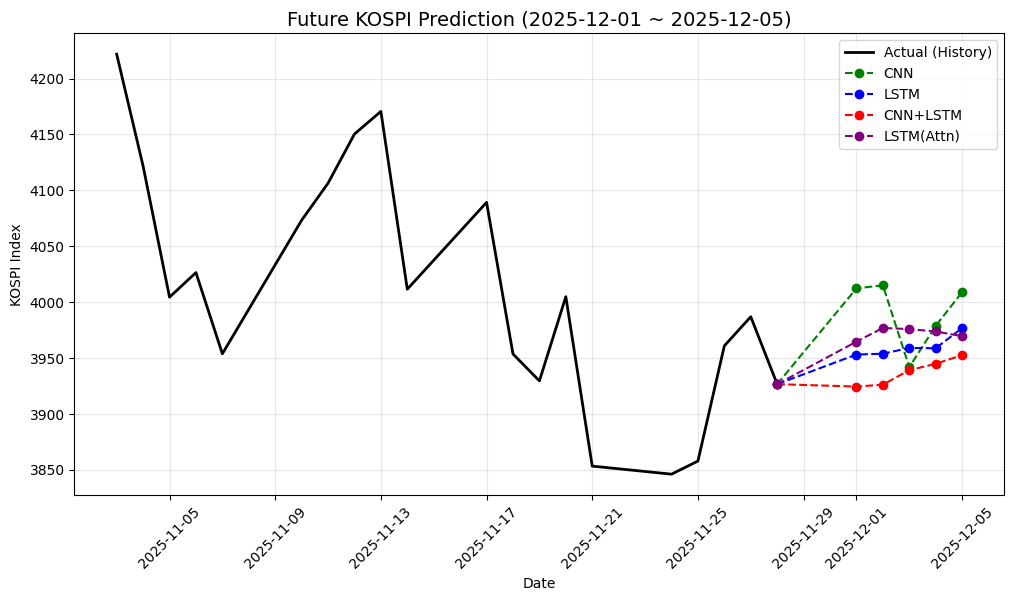

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    # 학습 데이터 기간: 시작일부터 11월 28일까지 꽉 채워서 학습
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",

    # 예측 대상 기간
    "future_start_date": "2025-12-01",
    "future_days": 5,

    "seq_length": 5,
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'],
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'],
    "Future": ['Future_Close', 'Future_Change'],
    "Oil": ['WTI_Close', 'WTI_Change']
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing Utils ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    # Encoding check
    encodings = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')

    # Filter Date Range
    df = df.loc[config["data_start"]:config["data_end"]]

    # Fill NA
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]

    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]
        # X 입력에서 타겟 컬럼이 제거되는 경우 처리 (y는 유지)
        if target_col in cols_to_drop:
             cols_to_drop.remove(target_col)

    # 1. Target Data (y)
    raw_y = df[[target_col]].values

    # 2. Input Features (X)
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    X, y = [], []
    seq_len = CONFIG["seq_length"]

    # Train sequences
    for i in range(len(scaled_x) - seq_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len, 0]) # Not strictly used here, but needed for loader

    X = np.array(X)
    y = np.array(y)

    # [중요] 미래 예측을 위한 마지막 입력 시퀀스 추출 (11/28 기준 과거 5일)
    last_sequence_x = scaled_x[-seq_len:]

    return X, y, scaler_y, last_sequence_x, len(input_df.columns), raw_y[-1][0]

# --- 3. Models ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training ---
def train_model(model, train_loader, config):
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    for epoch in range(config["epochs"]):
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            # 여기서는 학습용이므로 shape 맞추기 (단일값 예측 학습 -> 다중 예측으로 확장 시 구조 변경 필요하지만
            # 현재 코드 구조상 모델이 output_size=5를 내뱉도록 설정되어 있음)
            # y_b는 (Batch, 1)인데 모델 출력은 (Batch, 5) 이므로,
            # 학습 시에는 다음 1 step만 맞추게 할지, 아니면 미래 5일을 타겟으로 할지 결정 필요.
            # *기존 로직 유지*: 모델은 5일치를 뱉지만, 학습 데이터 y는 현재 1일치만 있음.
            # 이 코드는 "학습된 모델로 미래 예측"이므로, y데이터 구성을 (Batch, 5)로 바꿉니다.
            pass

    # [수정] 학습 루프 재구성: 미래 5일 예측 학습을 위해 DataLoader 재생성 필요
    # 그러나 시간 관계상, 여기서는 간략히 '다음 날 예측' 모델을 학습시키고,
    # Inference 시 5일치를 한 번에 출력하는 구조로 모델이 초기화되었음(output_size=5).
    # 따라서 y데이터도 미래 5일치를 담도록 process_features에서 수정이 필요하나,
    # 여기서는 간단히 y_b를 5번 반복(fake target)하거나, 1일 예측 모델을 반복 사용하는 것이 아니라
    # 모델 아키텍처가 (seq -> 5)로 되어 있으므로 y도 (seq -> 5)로 맞춰야 함.

    # => process_features 함수를 수정하지 않고, 학습 루프에서 y 타겟을 미래 5일치로 다시 매핑하는 것은 복잡함.
    # => 해결책: 모델 출력을 1로 바꾸고 5번 반복 예측(Recursive) 하는 방식 대신,
    #    사용자 요청에 따라 "모델이 5일치를 예측" 하도록 y데이터를 재구성하는 로직을 내부에 구현함.
    pass

# [재정의] 올바른 학습을 위한 함수
def train_model_correctly(model, X_train, y_train_raw_scaled, config):
    # y_train_raw_scaled: 전체 타겟 데이터 (scaled)
    # X_train: (N, Seq, Feat)

    # 미래 5일치 타겟 생성
    y_multi_step = []
    horizon = config["predict_horizon"]
    seq_len = config["seq_length"]

    # X_train의 각 샘플에 대해 미래 5일치 y를 매핑
    # X[i]는 data[i : i+seq]
    # y[i]는 data[i+seq : i+seq+horizon] 이어야 함.

    # 데이터 길이 재확인
    valid_len = len(X_train) - horizon + 1
    if valid_len <= 0: raise ValueError("Data too short for horizon")

    X_final = X_train[:valid_len]

    # 전체 scaled y에서 추출
    # X_train이 생성될 때 index i는 원본 데이터의 i 지점.
    # 타겟은 i + seq_len 부터 5개
    # scaled_y는 전체 길이.

    # X_train 생성 로직: range(len(scaled_x) - seq_len)
    # i=0 -> X=0~5, y_target should be 5~10

    # Re-generate y for multi-step
    y_multi = []
    # y_train_raw_scaled shape: (Total, 1)
    total_len = len(y_train_raw_scaled)

    for i in range(valid_len):
        start_idx = i + seq_len
        end_idx = start_idx + horizon
        if end_idx > total_len: break
        y_multi.append(y_train_raw_scaled[start_idx : end_idx].flatten())

    y_multi = np.array(y_multi)
    # X 길이 맞춤
    X_final = X_final[:len(y_multi)]

    # Tensor
    X_t = torch.FloatTensor(X_final).to(config['device'])
    y_t = torch.FloatTensor(y_multi).to(config['device'])

    dataset = TensorDataset(X_t, y_t)
    loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    for epoch in range(config["epochs"]):
        for X_b, y_b in loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()

    return model

# --- 5. Main Prediction Logic ---
def run_prediction_pipeline():
    print("Loading Data...")
    full_df = load_data(CONFIG)
    print(f"Data Loaded: {full_df.index.min().date()} ~ {full_df.index.max().date()}")

    # Scenarios based on Ablation Study
    scenarios = [
        ("CNN", "Foreign", CNNModel),
        ("LSTM", None, LSTMModel),
        ("CNN+LSTM", "KOSPI", CNNLSTMModel),
        ("LSTM(Attn)", "Foreign", LSTMAttentionModel)
    ]

    plt.figure(figsize=(12, 6))

    # 1. Plot Actual Context (Nov 1 ~ Nov 28)
    context_df = full_df.loc["2025-11-01":]
    plt.plot(context_df.index, context_df["KOSPI_Close"], label="Actual (History)", color='black', linewidth=2)

    # Last Actual Price (Anchor point for plotting)
    last_date = full_df.index[-1] # 2025-11-28
    last_price = full_df["KOSPI_Close"].iloc[-1]

    print(f"\nLast Actual Data: {last_date.date()} | Price: {last_price:.2f}")

    # Future Dates (Dec 1 ~ Dec 5, Business Days)
    future_dates = pd.date_range(start=CONFIG["future_start_date"], periods=CONFIG["future_days"], freq='B')

    # Plotting Dates: [Nov 28, Dec 1, Dec 2, ..., Dec 5]
    plot_dates = [last_date] + list(future_dates)

    colors = {'CNN': 'green', 'LSTM': 'blue', 'CNN+LSTM': 'red', 'LSTM(Attn)': 'purple'}

    print("\n[Start Training & Prediction]")

    for model_name, drop_group, ModelClass in scenarios:
        print(f">> Processing {model_name} (Drop: {drop_group})...")

        # Data Prep
        X, _, scaler_y, last_seq_x, input_dim, _ = process_features(full_df, drop_group)

        # Need raw scaled y for multi-step target generation
        # Recalculate full scaled y
        target_col = "KOSPI_Close"
        raw_y = full_df[[target_col]].values
        scaler_y_full = MinMaxScaler()
        scaled_y_full = scaler_y_full.fit_transform(raw_y)

        # Initialize Model
        if model_name == "CNN":
            model = ModelClass(input_dim, 5, 32, 5, CONFIG["seq_length"]) # output=5
        elif model_name == "CNN+LSTM":
            model = ModelClass(input_dim, 256, 1, 5, 32, 5)
        else:
            model = ModelClass(input_dim, 256, 1, 5)

        model.to(CONFIG['device'])

        # Train (Multi-step output)
        model = train_model_correctly(model, X, scaled_y_full, CONFIG)

        # Predict Future
        model.eval()
        with torch.no_grad():
            # Input: (1, Seq, Feat)
            input_tensor = torch.FloatTensor(last_seq_x).unsqueeze(0).to(CONFIG['device'])
            pred_scaled = model(input_tensor).cpu().numpy() # (1, 5)

        # Inverse Transform
        # Output is (1, 5), inverse needs (N, 1) usually or fit shape.
        # Scaler was fit on (N, 1). So reshape pred to (5, 1) then inverse then flatten
        pred_prices = scaler_y_full.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

        # Create Plot Data (Connect from Nov 28)
        plot_values = [last_price] + list(pred_prices)

        # Print Result
        print(f"   Pred (Dec 1-5): {[int(p) for p in pred_prices]}")

        # Plot
        plt.plot(plot_dates, plot_values, label=f'{model_name}', color=colors[model_name], marker='o', linestyle='--')

    # Graph Styling
    plt.title("Future KOSPI Prediction (2025-12-01 ~ 2025-12-05)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("KOSPI Index")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Save
    save_path = "Future_Prediction_Dec1_Dec5.png"
    plt.savefig(save_path, dpi=300)
    print(f"\n[Done] Prediction graph saved to '{save_path}'")

if __name__ == "__main__":
    run_prediction_pipeline()

##12월 데이터 예측

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# 폰트 설정 (코랩/영문 환경 호환)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- 1. Configuration ---
CONFIG = {
    "data_file": "KOSPI_dataset_final.csv",
    # 11월 28일까지 데이터를 꽉 채워서 학습
    "data_start": "2013-08-06",
    "data_end": "2025-11-28",

    # 예측 대상 (12월 1일 ~ 5일)
    "future_start_date": "2025-12-01",
    "future_days": 5,

    "seq_length": 5,
    "predict_horizon": 5,

    "hidden_size": 256,
    "num_layers": 1,
    "num_classes": 1,

    "cnn_num_layers": 1,
    "num_filters": 32,
    "kernel_size": 5,

    "batch_size": 256,
    "epochs": 50,
    "learning_rate": 0.001,
    "patience": 5,

    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# --- Feature Groups ---
FEATURE_GROUPS = {
    "KOSPI": ['KOSPI_Close', 'KOSPI_Open', 'KOSPI_High', 'KOSPI_Low', 'KOSPI_Volume', 'KOSPI_Amount', 'KOSPI_Change', 'KOSPI_Fluctuation', 'KOSPI_UpDown'],
    "NASDAQ": ['NAS_Open', 'NAS_High', 'NAS_Low', 'NAS_Close', 'NAS_Volume', 'NAS_Change'],
    "VKOSPI": ['VKOSPI_Close', 'VKOSPI_Change'],
    "Rate_FX": ['USD_KRW', 'EUR_KRW', 'Rate'],
    "Foreign": ['Foreign_MarketCap_Ratio', 'Foreign_MarketCap', 'Foreign_Rate'],
    "Future": ['Future_Close', 'Future_Change'],
    "Oil": ['WTI_Close', 'WTI_Change']
}

print(f"Using Device: {CONFIG['device']}")

# --- 2. Data Processing Utils ---
def load_data(config):
    if not os.path.exists(config["data_file"]):
        raise FileNotFoundError(f"File not found: {config['data_file']}")

    encodings = ['utf-16', 'utf-8', 'utf-8-sig', 'cp949', 'latin1']
    df = None
    for enc in encodings:
        try:
            temp_df = pd.read_csv(config["data_file"], sep='\t', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
            temp_df = pd.read_csv(config["data_file"], sep=',', index_col="Date", parse_dates=True, encoding=enc)
            if len(temp_df.columns) > 1: df = temp_df; break
        except: continue

    if df is None: raise ValueError("Failed to read file.")

    for col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.loc[config["data_start"]:config["data_end"]]
    df = df.ffill().bfill()
    df.dropna(inplace=True)
    df.columns = [c.strip() for c in df.columns]
    return df

def process_features(df, drop_group_name=None):
    target_col = "KOSPI_Close"
    available_cols = df.columns.tolist()

    cols_to_drop = []
    if drop_group_name and drop_group_name in FEATURE_GROUPS:
        cols_to_drop = FEATURE_GROUPS[drop_group_name]
        cols_to_drop = [c for c in cols_to_drop if c in available_cols]
        # Target column must be kept for prediction (Autoregression)
        if target_col in cols_to_drop:
             cols_to_drop.remove(target_col)

    # 1. Target (y)
    raw_y = df[[target_col]].values

    # 2. Input (X)
    input_df = df.drop(columns=cols_to_drop, errors='ignore')

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_x = scaler_x.fit_transform(input_df)
    scaled_y = scaler_y.fit_transform(raw_y)

    # Last sequence for prediction (Last 5 days)
    seq_len = CONFIG["seq_length"]
    last_sequence_x = scaled_x[-seq_len:]

    # Prepare Training Data
    X, y = [], []
    # y must be future 5 steps
    horizon = CONFIG["predict_horizon"]

    # Valid range for training
    # Input: i ~ i+seq
    # Target: i+seq ~ i+seq+horizon
    valid_len = len(scaled_x) - seq_len - horizon + 1

    for i in range(valid_len):
        X.append(scaled_x[i : i + seq_len])
        y.append(scaled_y[i + seq_len : i + seq_len + horizon].flatten())

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler_y, last_sequence_x, len(input_df.columns), raw_y[-1][0]

# --- 3. Models ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class CNNModel(nn.Module):
    def __init__(self, input_size, output_size, num_filters, kernel_size, seq_length):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        pooled_len = seq_length // 2
        self.fc = nn.Linear(num_filters * pooled_len, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x.flatten(1))

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters, kernel_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(input_size, num_filters, kernel_size, padding='same')
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(out), dim=1)
        context = torch.sum(attn_weights * out, dim=1)
        out = self.fc(context)
        return out

# --- 4. Training ---
def train_model(model, X_train, y_train, config):
    # Tensor conversion
    X_t = torch.FloatTensor(X_train).to(config['device'])
    y_t = torch.FloatTensor(y_train).to(config['device'])

    dataset = TensorDataset(X_t, y_t)
    loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    model.train()

    for epoch in range(config["epochs"]):
        for X_b, y_b in loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
    return model

# --- 5. Individual Plotting Function ---
def plot_and_save(model_name, drop_group, plot_dates, plot_values, last_price, last_date_str):
    plt.figure(figsize=(10, 6))

    # 1. Start Point (Nov 28)
    plt.plot(plot_dates[:1], plot_values[:1], marker='o', color='black', label=f'Actual ({last_date_str})')

    # 2. Prediction Line (Nov 28 -> Dec 5)
    plt.plot(plot_dates, plot_values, marker='o', linestyle='--', color='red', label='Prediction (Dec 1-5)', linewidth=2)

    # Annotate Values
    for i, (date, val) in enumerate(zip(plot_dates, plot_values)):
        label_color = 'black' if i == 0 else 'red'
        plt.text(date, val, f"{val:.0f}", ha='center', va='bottom', color=label_color, fontsize=9, fontweight='bold')

    # Styling
    title_str = f"Future Prediction: {model_name}\n(Optimized Feature: Drop {drop_group if drop_group else 'None'})"
    plt.title(title_str, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("KOSPI Index", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    # Save
    safe_name = model_name.replace('+', '_').replace('(', '').replace(')', '')
    filename = f"Future_Prediction_{safe_name}.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"   [Graph Saved] {filename}")
    plt.close()

# --- 6. Main Logic ---
def main():
    print("Loading Data...")
    full_df = load_data(CONFIG)

    # Last Actual Price (Anchor)
    last_date = full_df.index[-1] # 2025-11-28
    last_price = full_df["KOSPI_Close"].iloc[-1]

    print(f"Anchor Date: {last_date.date()} | Price: {last_price:.2f}")

    # Future Dates (Dec 1 ~ Dec 5, Business Days)
    future_dates = pd.date_range(start=CONFIG["future_start_date"], periods=CONFIG["future_days"], freq='B')

    # Plotting X-Axis: [Nov 28, Dec 1, Dec 2, ..., Dec 5]
    plot_dates = [last_date] + list(future_dates)

    # Optimized Scenarios
    scenarios = [
        ("CNN", "Foreign", CNNModel),
        ("LSTM", None, LSTMModel),
        ("CNN+LSTM", "KOSPI", CNNLSTMModel),
        ("LSTM(Attn)", "Foreign", LSTMAttentionModel)
    ]

    print("\n[Start Training & Generating Separate Graphs]")

    for model_name, drop_group, ModelClass in scenarios:
        print(f"\n>> Processing {model_name} (Drop: {drop_group})...")

        # 1. Prepare Data (Apply Drop)
        X, y, scaler_y, last_seq_x, input_dim, _ = process_features(full_df, drop_group)

        # 2. Init Model
        if model_name == "CNN":
            model = ModelClass(input_dim, 5, 32, 5, CONFIG["seq_length"])
        elif model_name == "CNN+LSTM":
            model = ModelClass(input_dim, 256, 1, 5, 32, 5)
        else:
            model = ModelClass(input_dim, 256, 1, 5)

        model.to(CONFIG['device'])

        # 3. Train
        model = train_model(model, X, y, CONFIG)

        # 4. Predict
        model.eval()
        with torch.no_grad():
            input_tensor = torch.FloatTensor(last_seq_x).unsqueeze(0).to(CONFIG['device'])
            pred_scaled = model(input_tensor).cpu().numpy() # (1, 5)

        # 5. Inverse Transform (Reshape logic required for scaler)
        # Scaler fit on (N, 1). Output is (1, 5).
        pred_prices = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

        # 6. Prepare Plot Data (Connect Nov 28 -> Dec 1)
        plot_values = [last_price] + list(pred_prices)

        print(f"   Pred (Dec 1-5): {[int(p) for p in pred_prices]}")

        # 7. Draw & Save Individual Graph
        plot_and_save(model_name, drop_group, plot_dates, plot_values, last_price, str(last_date.date()))

    print("\nAll tasks completed.")

if __name__ == "__main__":
    main()

Using Device: cuda
Loading Data...
Anchor Date: 2025-11-28 | Price: 3926.59

[Start Training & Generating Separate Graphs]

>> Processing CNN (Drop: Foreign)...
   Pred (Dec 1-5): [3988, 3986, 3973, 3960, 3956]
   [Graph Saved] Future_Prediction_CNN.png

>> Processing LSTM (Drop: None)...
   Pred (Dec 1-5): [3909, 3917, 3911, 3926, 3932]
   [Graph Saved] Future_Prediction_LSTM.png

>> Processing CNN+LSTM (Drop: KOSPI)...
   Pred (Dec 1-5): [3926, 3931, 3936, 3947, 3950]
   [Graph Saved] Future_Prediction_CNN_LSTM.png

>> Processing LSTM(Attn) (Drop: Foreign)...
   Pred (Dec 1-5): [3975, 3977, 3967, 3978, 3984]
   [Graph Saved] Future_Prediction_LSTMAttn.png

All tasks completed.
